## figure out normalization and difference from last time...


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from numba import njit
# from scipy import odr
# from scipy.special import voigt_profile
from scipy.optimize import curve_fit
# from scipy import stats as st
import time
import math

# os.chdir('F:/LANL/processed_data/')
# processedfolder = 'F:/LANL/processed_data/'

os.chdir('F:/LANL/')
# os.chdir('/mnt/c/Users/gabeo/Desktop/analysis_temp/')
root = os.getcwd()

processedfolder = '/processed_data/'

search_arr = sorted(os.listdir(root + processedfolder))
print(search_arr)
# print(search_arr[0])

# folders_start = 'runs'+'12686-13279'
# folders_end = 'runs'+'12686-13279'
folders_start = 'runs'+'11727-12033'
# folders_end = 'runs'+'12034-12363'
folders_end = 'runs'+'12364-12684'

print(folders_start)
start_i = search_arr.index(folders_start)
end_i = search_arr.index(folders_end)
print(start_i, end_i)
print(len(search_arr[start_i:end_i+1]))
asymDendname = '/asym_swave_D/'
asymUendname = '/asym_swave_U/'

firstfile = sorted(os.listdir(root+processedfolder+folders_start+asymDendname))[0]
folderslist = []
if folders_start == folders_end:
    currfolder = search_arr[start_i]+'/'
    folderslist.append(currfolder)
else:
    for f in range(start_i, end_i+1):
        currfolder = root+processedfolder+search_arr[f]
        currfolder = search_arr[f]+'/'
        # print(currfolder)
        folderslist.append(currfolder)
#     runslist_D[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D'))
#     runslist_U[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_U'))

numfolders = len(folderslist)
print(folderslist)
print(numfolders)

## change below to multiple folders?
runslist_D = []  ## array of runfolders, runs
runslist_U = []
for i in range(len(folderslist)):
    runslist_D.append(sorted(os.listdir(root+processedfolder+folderslist[i]+asymDendname)))
    runslist_U.append(sorted(os.listdir(root+processedfolder+folderslist[i]+asymUendname)))
# runslist_D = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_D')) ## has to be changed to an array
# runslist_U = sorted(os.listdir(root+processedfolder+folders_start+'/ONOFF_U'))
# runslist_D =np.asarray(runslist_D)
# runslist_U =np.asarray(runslist_U)
print(len(runslist_D))
print(len(runslist_D[0]))
# print(len(runslist_D[1]))
## now flatten list so that all runs are in one array ## not sure I will use this
flatrunslist_D = [run for folder in runslist_D for run in folder]
flatrunslist_D = np.asarray(flatrunslist_D)
flatrunslist_U = [run for folder in runslist_U for run in folder]
flatrunslist_U = np.asarray(flatrunslist_U)
print(len(flatrunslist_D))

numruns_tot_D = len(flatrunslist_D) ## U and D should be the same? ## should change to num pulses maybe
numruns_tot_U = len(flatrunslist_U) ## 
if numruns_tot_D != numruns_tot_U:
    emessage = ('# upstream files and downstream files are not the same!')
    # logger.error(run_num + emessage)
    raise Exception(emessage)
print(numruns_tot_D)
print(numruns_tot_U)

['0_vparams_La.h5', '1_vparams_Pr.h5', 'La_sample', '_temp_xs.npy', 'runs07862-08069', 'runs09919-10159', 'runs11121-11138', 'runs11139-11412', 'runs11413-11726', 'runs11727-12033', 'runs12034-12363', 'runs12364-12684', 'runs12686-13279', 'runs13280-13563', 'runs13564-13604', 'runs13605-13735', 'runs13736-13851', 'runs13852-14191', 'runs14192-14499', 'runs14500-15106', 'runs15114-15568', 'runs15569-16110', 'runs16135-16392', 'runs16453-16763', 'runs88888-99999', 's_vparams_La.h5', 'xs_cut.npy', 'xs_uncut.npy']
runs11727-12033
9 11
3
['runs11727-12033/', 'runs12034-12363/', 'runs12364-12684/']
3
3
306
954
954
954


In [2]:
## allows h5 loads to be easier...
foldersflat = []
for i in range(0,len(folderslist)):
    folder = folderslist[i]
    numrunsfolder = len(runslist_D[i])
    fpaths = [folder]*numrunsfolder
    foldersflat.append(fpaths)

foldersflat = [path for folder in foldersflat for path in folder]
# print(foldersflat[0])
print(len(foldersflat))
# print(len(foldersflat[0]))
# print(len(foldersflat[1]))
# print(len(foldersflat))
# print(foldersflat)

954


In [3]:
# print(len(runslist_D))
# print(len(runslist_D[0]))
# print(len(runslist_D[1]))
# ## now flatten list so that all runs are in one array ## not sure I will use this
# flatrunslist_D = [run for folder in runslist_D for run in folder]
# flatrunslist_D = np.asarray(flatrunslist_D)
# flatrunslist_U = [run for folder in runslist_U for run in folder]
# flatrunslist_U = np.asarray(flatrunslist_U)
# print(len(flatrunslist_D))

# numruns_tot_D = len(flatrunslist_D) ## U and D should be the same? ## should change to num pulses maybe
# numruns_tot_U = len(flatrunslist_U) ## 
# print(numruns_tot_D)
# print(numruns_tot_U)

In [4]:
## load in the x array. Also helps in determining sizes
## NO 6LI FOR THESE HDF5 FILES

channels_all = []
folderpath = root+processedfolder+folderslist[0]
with h5py.File(folderpath+asymDendname+runslist_D[0][0], 'r') as f: ## new arr_sizer
    channels_D = list(f.keys())
    channels_all.append(channels_D[:-1])
    numchannels = len(channels_D)-1
    dataset = f[channels_D[-1]]   ## this is the xs dataset
#     xs = np.array(dataset)*1e-6 ## now in ms
#     numpoints = len(xs)
    f.close()
    
with h5py.File(folderpath+asymUendname+runslist_U[0][0], 'r') as f: ## new arr_sizer
    channels_U = list(f.keys())
    channels_all=np.append(channels_all, channels_U[:-1])
#     channels_all.append(channels[:-1])
    numchannels = len(channels_U)-1
    dataset = f[channels_U[-1]]   ## this is the xs dataset
    xs = np.array(dataset)*1e-6 ## now in ms
    numpoints = len(xs)
    f.close()
# print(channels_all)
# channels_all = np.asarray(channels_all, dtype=object)
# print(channels_all)
# channels_all = channels_all.flatten()
print(numruns_tot_D,numchannels,numpoints)
# print(data.shape)
# print(data[seq][0][0])
# print(channels_all[:])
print(channels_all[-1])
print(len(xs))

print(channels_D)
print(channels_U)
print(channels_all)

# print(channels_all.flatten())
# print(data)

954 13 8992
ch_24
8992
['ch_00', 'ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07', 'ch_08', 'ch_09', 'ch_10', 'ch_11', 'ch_24', 'xs ']
['ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23', 'ch_24', 'xs ']
['ch_00' 'ch_01' 'ch_02' 'ch_03' 'ch_04' 'ch_05' 'ch_06' 'ch_07' 'ch_08'
 'ch_09' 'ch_10' 'ch_11' 'ch_24' 'ch_12' 'ch_13' 'ch_14' 'ch_15' 'ch_16'
 'ch_17' 'ch_18' 'ch_19' 'ch_20' 'ch_21' 'ch_22' 'ch_23' 'ch_24']


In [5]:
# ## loads on/off added pulses. not needed for asym based on multiplicative factor ##
numsequences = []
# run_ampasym_D = []
# run_ampasym_U = []
run_rawasym_D = []
run_rawasym_U = []
# totnumchan = len(run_asyms_D[0])+len(run_asyms_U_noLi[0])

folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders

for i in range(0,len(runslist_D)):
    runname = folderpath+asymDendname+runslist_D[0][i]  ##[0] indicates the first folder
    print(runname)
    with h5py.File(runname, 'r') as f:
        # print("Keys: %s" % f.keys())
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        numsequences.append(num_seq)
        # runamp = []
        runraw = []
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        for i in range(0,numchannels):
            chsubgrp = f[channels[i]]  ##change this to match channels[i]
            print(chsubgrp)
# #             print(list(chsubgrp.attrs))
#             print((chsubgrp.attrs.get('asym_amp')))
            # asym_amp_data = np.array(chsubgrp.attrs.get('asym_amp'))
            # print(asym_amp_data[0])
            asym_raw_chdataset = np.array(chsubgrp['asym_raw'])
#             print(asym_raw_chdataset)
            # runamp.append(asym_amp_data)
            runraw.append(asym_raw_chdataset)
        # run_ampasym_D.append(runamp)
        run_rawasym_D.append(runraw)
        f.close()
#         folderpath = root+processedfolder+folderslist[0]  ## generalize this to all folders


F:\LANL/processed_data/runs11727-12033//asym_swave_D/11727_swave_D.h5
<HDF5 group "/ch_00" (3 members)>
<HDF5 group "/ch_01" (3 members)>
<HDF5 group "/ch_02" (3 members)>
<HDF5 group "/ch_03" (3 members)>
<HDF5 group "/ch_04" (3 members)>
<HDF5 group "/ch_05" (3 members)>
<HDF5 group "/ch_06" (3 members)>
<HDF5 group "/ch_07" (3 members)>
<HDF5 group "/ch_08" (3 members)>
<HDF5 group "/ch_09" (3 members)>
<HDF5 group "/ch_10" (3 members)>
<HDF5 group "/ch_11" (3 members)>
<HDF5 group "/ch_24" (1 members)>
F:\LANL/processed_data/runs11727-12033//asym_swave_D/11728_swave_D.h5
<HDF5 group "/ch_00" (3 members)>
<HDF5 group "/ch_01" (3 members)>
<HDF5 group "/ch_02" (3 members)>
<HDF5 group "/ch_03" (3 members)>
<HDF5 group "/ch_04" (3 members)>
<HDF5 group "/ch_05" (3 members)>
<HDF5 group "/ch_06" (3 members)>
<HDF5 group "/ch_07" (3 members)>
<HDF5 group "/ch_08" (3 members)>
<HDF5 group "/ch_09" (3 members)>
<HDF5 group "/ch_10" (3 members)>
<HDF5 group "/ch_11" (3 members)>
<HDF5 grou

In [6]:

def loadrun_asym(run, processedpath): ## not sure if this is the fastest way, or passing a list of runs...
    runname = processedpath+run
    runamp = []
    runintegral = []
#     print(runname)
#     numsequences = []
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        num_seq = f.attrs.get('sequences')
        puck = f.attrs.get('puck_state')
#         print(puck)
        # if puck != 0:
        #     print(run, puck)
        runraw = np.zeros((numchannels,numpoints),dtype = np.float64) ## numpoints gotten from few cells up
        for i in range(0,numchannels):
            chsubgrp = f[channels[i]]
            # print(chsubgrp.name[1:])
            chraw = np.array(chsubgrp['asym_raw'])  ##change this to match channels[i]
            runraw[i] = runraw[i]+chraw
            if chsubgrp.name[1:] != 'ch_24': 
                # print('6Li')
                runampch = np.array(chsubgrp.attrs.get('asym_amp'))
                runamp.append(runampch[0])  #[0] is the asym from amp as opposed to the error [1]
                runintegralch = chsubgrp.attrs.get('asym_integral')
                runintegral.append(runintegralch)  # currently no error for integral, just scaler
        f.close()
#     print((runamp))
#     print(num_seq)
    return runraw, runamp, runintegral, num_seq 

start=time.time()
# all_D = [] ## in this case cannot be np array because it is not same size arrays ## will be run, channel, numpoints
all_raw_D      = np.zeros((numruns_tot_D, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_raw_U      = np.zeros((numruns_tot_U, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_amp_D      = np.zeros((numruns_tot_D, numchannels-1),dtype = np.float64) ## run, channel. amplitude only for the NaI detectors
all_amp_U      = np.zeros((numruns_tot_U, numchannels-1),dtype = np.float64) ## run, channel. amplitude only for the NaI detectors
all_integral_D = np.zeros((numruns_tot_D, numchannels-1),dtype = np.float64) ## run, channel 
all_integral_U = np.zeros((numruns_tot_U, numchannels-1),dtype = np.float64) ## run, channel 
all_sequences  = np.zeros((numruns_tot_D),dtype = np.uint16) ## num runs
# print(len(all_amp_D))

for r in range(0, len(flatrunslist_D)):
    fpath = root+processedfolder+foldersflat[r]
    full = len(flatrunslist_D)
#     print(fpath)
#     print(len(all_amp_D[r]))
    if r == round(full/5) or r == round(2*full/5) or r == round(3*full/5) or r == round(4*full/5) or r == full-1:
        print('1/5 runs complete ', r)
#     print(flatrunslist_D[r])
    all_raw_D[r], all_amp_D[r], all_integral_D[r], all_sequences[r] = loadrun_asym(flatrunslist_D[r], fpath+asymDendname)
    all_raw_U[r], all_amp_U[r], all_integral_U[r], all_sequences[r] = loadrun_asym(flatrunslist_U[r], fpath+asymUendname)

print(all_raw_D.shape)
all_raw_D = np.asarray(all_raw_D.transpose(1,0,2))  ## re-shape into ch, run, points
all_raw_U = np.asarray(all_raw_U.transpose(1,0,2))
print(all_raw_D.shape)

print(all_amp_D.shape)
all_amp_D = np.asarray(all_amp_D.transpose(1,0))
all_amp_U = np.asarray(all_amp_U.transpose(1,0))
print(all_amp_D.shape)

print(all_integral_D.shape)
all_integral_D = np.asarray(all_integral_D.transpose(1,0))
all_integral_U = np.asarray(all_integral_U.transpose(1,0))
print(all_integral_D.shape)

all_amp = np.vstack((all_amp_D,all_amp_U))
all_integral = np.vstack((all_integral_D,all_integral_U))

# all_amp_norm = all_amp/(all_sequences) # need weighted avg?
# all_integral_norm = all_integral/(all_sequences) # need weighted avg?

end=time.time()
print('loaded files time: ', end-start)

1/5 runs complete  191
1/5 runs complete  382
1/5 runs complete  572
1/5 runs complete  763
1/5 runs complete  953
(954, 13, 8992)
(13, 954, 8992)
(954, 12)
(12, 954)
(954, 12)
(12, 954)
loaded files time:  113.50448393821716


In [7]:
ch = 13
r = 63
print(all_amp[ch][r])
print(all_integral[ch][r])

-0.03373510861606975
-0.03378876958847355


In [8]:
print(np.sum(all_amp[0])/np.sum(all_sequences))
print(np.mean(all_amp[0])/13)
print(all_amp[1].shape)
# print(all_amp[1])np.load('asym_all_detectors.npz').files
# print(all_sequences)

-0.00015682656231230506
-0.0001566748191460619
(954,)


In [9]:
## get rid of problem outlier runs above a threshold. Runs are taken out for all channels. Oriinal arrays kept.
print(channels_D[-1], channels_U[-1])
if channels_D[-1] == 'xs ': ## get rid of the xs channel, but can rerun cell multiple times.
    channels_D, channels_U = channels_D[:-1], channels_U[:-1]
print(channels_D[0],channels_D[-1], channels_U[0], channels_U[-1])

## checks to see if already made so I can rerun cell
if "all_raw_D_og" not in globals():
    all_raw_D_og = np.copy(all_raw_D)
if "all_raw_U_og" not in globals():
    all_raw_U_og = np.copy(all_raw_U)
all_raw_D = np.copy(all_raw_D_og)
all_raw_U = np.copy(all_raw_U_og)

problem_files_D = [[],[]] ## ch, run file
problem_files_U = [[],[]]
outlier_thresh = 10000 ################################################ thresh
start_b = 2300 # start looking after this bin.

for ch in range(0, len(all_raw_D)):
    for i in range(0, len(all_raw_D[0])):
        if np.max(np.abs(all_raw_D[ch,i,start_b:])) >= outlier_thresh:
            problem_files_D[0].append(channels_D[ch])
            problem_files_D[1].append(i) 

for ch in range(0, len(all_raw_U)):
    for i in range(0, len(all_raw_U[0])):
        if np.max(np.abs(all_raw_U[ch,i,start_b:])) >= outlier_thresh:
            problem_files_U[0].append(channels_U[ch])
            problem_files_U[1].append(i)

# print(np.unique(np.sort(problem_files_D[1])))
# print(np.unique(np.sort(problem_files_U[1])))
outlier_runs = np.int32(np.unique(np.sort(np.append(problem_files_D[1],problem_files_U[1]))))
print(outlier_runs)

if len(outlier_runs) > 0 :
    all_raw_D, all_raw_U = np.delete(all_raw_D_og, outlier_runs, axis=1), np.delete(all_raw_U_og, outlier_runs, axis=1)
    print(f'deleted {len(outlier_runs)} outlier runs')
print(all_raw_D_og.shape, all_raw_U_og.shape)
print(all_raw_D.shape, all_raw_U.shape)

# np.delete(test_del, test_prob_f, axis=1)


all_raw = np.vstack((all_raw_D[:-1],all_raw_U)) ## now put them all together. Take out 6Li in _D
all_raw_og = np.vstack((all_raw_D_og[:-1],all_raw_U_og)) ## now put them all together. Take out 6Li in _D
print(all_raw_og.shape)
print(all_raw.shape)
# del all_raw_D ## might help with memory issues
# del all_raw_U

xs  xs 
ch_00 ch_24 ch_12 ch_24
[109]
deleted 1 outlier runs
(13, 954, 8992) (13, 954, 8992)
(13, 953, 8992) (13, 953, 8992)
(25, 954, 8992)
(25, 953, 8992)


In [10]:
## add up all runs

sum_ch_raw = []
sum_ch_amp = []
# p1 = 300
# p2 = 400
for ch in range(0, len(all_raw)):
    # chraw = np.sum(all_raw[ch,p1:p2], axis = 0)
    chraw = np.sum(all_raw[ch,:], axis = 0)
    sum_ch_raw.append(chraw)
for ch in range(0, len(all_amp)):
    champ = np.sum(all_amp[ch,:], axis = 0)
    sum_ch_amp.append(champ)

sum_ch_raw = np.array(sum_ch_raw)
    
sum_ch_amp = sum_ch_amp/np.sum(all_sequences) ## normalize sum of amplitudes!
    
print(len(sum_ch_raw), len(sum_ch_amp))
print(len(sum_ch_raw[0]))
allNaI_raw = np.sum(sum_ch_raw[0:23], axis = 0)

25 24
8992


8992


(-0.01, 4.0)

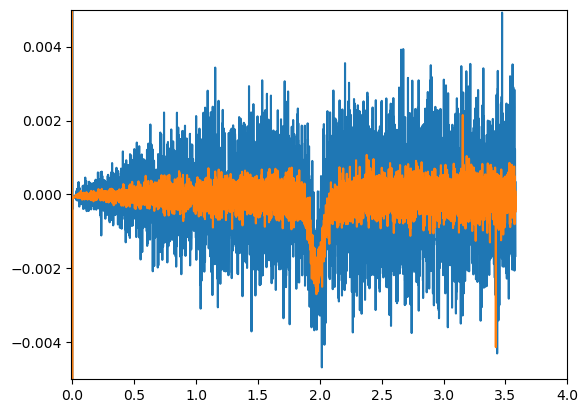

In [11]:
# check this
%matplotlib inline
print(len(allNaI_raw))
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.005, 0.005)
plt.xlim(-0.01, 4.0)

In [12]:
fpl = 23.31
daq_delay = 0

m_n = 1.6749286*10**(-27)
# L = 0
J_to_eV = 6.24151*10**18
eV_to_J = 1.602176565*10**-19

def tof_to_eV(xtof, FPlength, t_off):
    m_n = 1.6749286*10**(-27)
    delay = t_off
    x_eV_out = 0.5*m_n*((FPlength/((xtof+delay)/1000)))**2*J_to_eV  ## tof in ms
    return x_eV_out
def eV_to_tof(xeV, FPlength, t_off):
    m_n = 1.6749286*10**(-27)
    delay = t_off
    x_tof_out = delay + 1000*FPlength*np.sqrt(m_n/(2*xeV*eV_to_J))  ## tof in ms
    return x_tof_out

In [13]:
print(tof_to_eV(0.780, fpl, daq_delay))
print(eV_to_tof(4.79, fpl, daq_delay))

4.668220001093984
0.7700208426295269


In [14]:
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                    all_raw_og:  1.6 GiB
                       all_raw:  1.6 GiB
                  all_raw_D_og: 850.8 MiB
                  all_raw_U_og: 850.8 MiB
                     all_raw_D: 849.9 MiB
                     all_raw_U: 849.9 MiB
                    sum_ch_raw:  1.7 MiB
                       all_amp: 179.0 KiB
                  all_integral: 179.0 KiB
                            xs: 70.4 KiB


In [15]:
del all_raw_D_og ## might help with memory issues
del all_raw_U_og
del all_raw_og
# del run_rawasym_D
# del run_rawasym_U
# del run_ampasym_D
# del run_ampasym_U
# del flatrunslist_D
# del flatrunslist_U
# del asym_raw_chdataset

In [16]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       all_raw:  1.6 GiB
                     all_raw_D: 849.9 MiB
                     all_raw_U: 849.9 MiB
                    sum_ch_raw:  1.7 MiB
                       all_amp: 179.0 KiB
                  all_integral: 179.0 KiB
                            xs: 70.4 KiB
            asym_raw_chdataset: 70.4 KiB
                         chraw: 70.4 KiB
                    allNaI_raw: 70.4 KiB


In [17]:

def loadrun_pulseadd(run, processedpath): ## not sure if this is the fastest way, or passing a list of runs...
    runname = processedpath+run
#     print(runname)
    with h5py.File(runname, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels)-1
        arrsizer = f[channels[-1]] ## gets the xs array
        arrsizer = np.asarray(arrsizer)
        numpoints = len(arrsizer)
#             num_seq = f.attrs.get('sequences')
#             numsequences.append(num_seq)
        rundat = np.zeros((numchannels,numpoints),dtype = np.float64)
#             print(str(np.char.zfill(str(chan_enab[i]),2)))
#             dataset = f['ch '+str(np.char.zfill(str(chan_enab[i]), 2))]
        for i in range(0,numchannels):
            dataset = f[channels[i]+'/added_pulses/'+channels[i]][:]  ##change this to match channels[i]
            chdata = np.array(dataset)
#                     print(chdata)
#                     print(np.size(chdata))
#                     print(len(chdata[0]))
#                     print(rundat)
            rundat[i] = rundat[i]+chdata
        f.close()
    return rundat

start=time.time()
# all_D = [] 
# all_D = np.zeros((numruns_tot_D, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
# all_U = np.zeros((numruns_tot_U, numchannels,numpoints),dtype = np.float64) ## run, channel, numpoints ## works if flatten the folders
all_D = [] ## in this case cannot be np array because it is not same size arrays ## will be run, channel, numpoints
all_U = []

for f in range(0,len(folderslist)):
    fpath = root+processedfolder+folderslist[f]
    print(fpath)
    for r in range(0, len(runslist_D[f])):
        # print(runslist_D[f][r])
        all_D.append(loadrun_pulseadd(runslist_D[f][r][:5]+'_pulseadd_D.h5', fpath+'/pulseadd_D/'))  ## added pulseadd str to this
        all_U.append(loadrun_pulseadd(runslist_U[f][r][:5]+'_pulseadd_U.h5', fpath+'/pulseadd_U/'))
#         print(all_D[r])
    print(fpath+' done')

all_D = np.asarray(all_D)
all_U = np.asarray(all_U)
    
print('original downstream dets shape', all_D.shape)
all_D = np.asarray(all_D.transpose(1,0,2))  ## re-shape into ch, run, points
all_U = np.asarray(all_U.transpose(1,0,2))
print('new downstream dets shape', all_D.shape)
    
end=time.time()
print('loaded pulseadd files time: ', end-start)

F:\LANL/processed_data/runs11727-12033/
F:\LANL/processed_data/runs11727-12033/ done
F:\LANL/processed_data/runs12034-12363/
F:\LANL/processed_data/runs12034-12363/ done
F:\LANL/processed_data/runs12364-12684/
F:\LANL/processed_data/runs12364-12684/ done
original downstream dets shape (954, 13, 8992)
new downstream dets shape (13, 954, 8992)
loaded pulseadd files time:  97.01030564308167


In [18]:
np.set_printoptions(suppress=True, precision=6)

In [19]:
## make an array of random seq asym values for autocorr. Better than repeating same run asym value 13 times.

window = 0.018/13
seq_rands = []
for ch in range(0, len(all_amp)):
    run_rands = []
    for r in range(0, len(all_amp[ch])):
        run_rand = []
        target = all_amp[ch][r]
        seqsize = all_sequences[r]
        # print(target)
        random_floats_arr = np.random.default_rng().uniform(low=(target/13-window), high=((target/13+window)), size=seqsize)
        run_rands.append(random_floats_arr)
        # print(np.sum(random_floats_arr), all_amp[ch][r])
    flat_rands = [item for sublist in run_rands for item in sublist]
    flat_rands = np.array(flat_rands)
    seq_rands.append(flat_rands)
    # print(flat_rands.shape)

seq_rands = np.array(seq_rands)
print(seq_rands.shape)


(24, 12390)


(12390,)
Detector: 5
R (runs): 954
N_seq (per detector): 12390
rho1: 0.9044641103587016
noise_level (2/sqrt(N)): 0.017967776735230836
cutoff lag: 12
tau_sum (truncated): 12.405768655398239
N_eff (truncated): 998.7289255638846
mu (weighted per-run mean): -0.002120070353413509
sigma_w (weighted std): 0.07962814157539948
SE_seq: 0.000715370334834065
SE_run: 0.002578056271932273
SE_neff: 0.002519664782171682


<>:91: SyntaxWarning: invalid escape sequence '\h'
<>:91: SyntaxWarning: invalid escape sequence '\h'
C:\Users\gabeo\AppData\Local\Temp\ipykernel_24912\2813498917.py:91: SyntaxWarning: invalid escape sequence '\h'
  plt.title(f'Autocorrelation $\hat\\rho_k$, det. {det}, runs organized with $N_{{seq}}$')


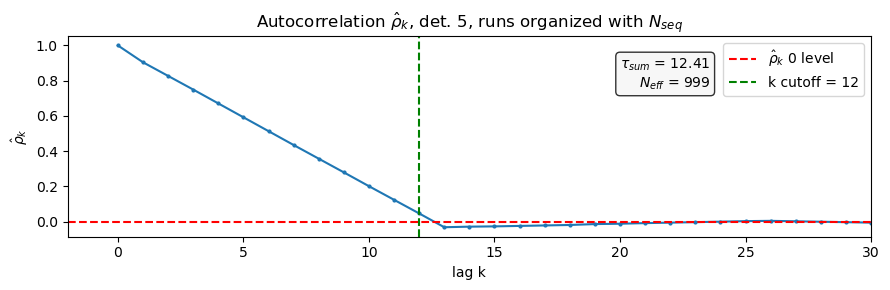

In [20]:
%matplotlib inline
# -------------- load data --------------
# data = np.load("F:/LANL/asym_all_detectors.npz")
# Nr = data["arr1"].astype(int)   # shape (R,)
# A = data["arr2"].astype(float)  # shape (D, R)

Nr = np.asarray(all_sequences, dtype =np.int32)   # shape (R,)
A = all_amp  # shape (D, R)
# print(type(Nr[0]), type(A[0][0]))
D, R = A.shape
N_seq = int(Nr.sum())

# choose detector (zero-based index)
det = 5

# -------------- flatten per-sequence series --------------
per_run = A[det]                # length R
# seq_series = np.repeat(per_run, Nr)   # length N_seq
seq_series = seq_rands[det]   # length N_seq
print(seq_series.shape)
# run_series = all_amp[det]

# -------------- autocorr estimator (normalized) --------------
def autocorr_rho_full(x, max_lag=None):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if max_lag is None or max_lag > n-1:
        max_lag = n-1
    xm = x - x.mean()
    denom = np.sum(xm * xm)
    corr_full = np.correlate(xm, xm, mode='full')
    corr = corr_full[n-1:n+max_lag+1]    # lags 0..max_lag
    rho = corr / denom
    return rho  # rho[0] = 1

max_lag = min(2000, N_seq-1)
rho = autocorr_rho_full(seq_series, max_lag=max_lag)
# rho = autocorr_rho_full(run_series, max_lag=max_lag)

# -------------- cutoff rule (first negative or below noise) --------------
noise_level = 2.0 / math.sqrt(N_seq)
cutoff = max_lag
for k in range(1, len(rho)):
    if rho[k] < 0 or rho[k] < noise_level:
        cutoff = k-1
        break

# -------------- tau, Neff --------------
if cutoff >= 1:
    tau_sum = 1.0 + 2.0 * np.sum(rho[1:cutoff+1])
else:
    tau_sum = 1.0
Neff_sum = N_seq / tau_sum if tau_sum > 0 else 1.0
# Neff_sum = R / tau_sum if tau_sum > 0 else 1.0


# -------------- weighted std and SEs --------------
# weighted mean per-run for this detector:
mu = np.average(per_run, weights=Nr)
var_w = np.sum(Nr * (per_run - mu)**2) / N_seq
sigma_w = math.sqrt(var_w)

SE_seq = sigma_w / math.sqrt(N_seq)
SE_run = sigma_w / math.sqrt(R)
SE_neff = sigma_w / math.sqrt(Neff_sum)

# -------------- print results --------------
print("Detector:", det)
print("R (runs):", R)
print("N_seq (per detector):", N_seq)
print("rho1:", rho[1])
print("noise_level (2/sqrt(N)):", noise_level)
print("cutoff lag:", cutoff)
print("tau_sum (truncated):", tau_sum)
print("N_eff (truncated):", Neff_sum)
print("mu (weighted per-run mean):", mu)
print("sigma_w (weighted std):", sigma_w)
print("SE_seq:", SE_seq)
print("SE_run:", SE_run)
print("SE_neff:", SE_neff)

# -------------- plot rho_k --------------
lags = np.arange(len(rho))
plt.figure(figsize=(9,3))
plt.plot(lags[:200], rho[:200], marker='.', markersize=4, linestyle='-')
# plt.axhline(noise_level, color='red', linestyle='--', label=f'noise level = {noise_level:.4f}')
plt.axhline(0, color='red', linestyle='--', label=r'$\hat\rho_k$ 0 level')
plt.axvline(cutoff, color='green', linestyle='--', label=f'k cutoff = {cutoff}')
plt.xlabel('lag k')
plt.ylabel(r'$\hat\rho_k$')
plt.title(f'Autocorrelation $\hat\\rho_k$, det. {det}, runs organized with $N_{{seq}}$')
plt.xlim(-2, 30)
plt.legend()

# Create a text box next to the legend
textstr = f'$\\tau_{{sum}}$ = {tau_sum:.2f}\n$N_{{eff}}$ = {Neff_sum:.0f}'

# Get the legend box position
leg = plt.gca().get_legend()
if leg:
    bbox = leg.get_frame().get_bbox()
    x0 = bbox.x1 - 0.05  # small offset to the right of legend
    y0 = bbox.y0 + 0.05
else:
    x0, y0 = 0.8, 0.8  # fallback position

# Place the annotation box
plt.gca().text(0.8, 0.9, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='whitesmoke', alpha=0.8))

plt.tight_layout()
plt.show()


In [21]:
def w_asym(asym_array, sequences, N_input):
    # Check if multiple detectors or not
    single_channel = False
    if asym_array.ndim == 1:
        single_channel = True
        asym_array = asym_array[None, :]  # shape (1, R)
    ## definitions for clarity
    D, R = asym_array.shape  # number of detectors, runs
    # N_r = sequences              # sequences per run
    N_s = np.sum(sequences)          # total sequences per detector
    N_tot = D*N_input  ## this is N_eff, but generalized to be N_r, N_seq, or N_eff from autocorr.,etc. D accounts for # detectors, 1 (D=1) or multiple

    # weighted mean per det
    weighted_sum = np.sum(asym_array * sequences[None, :], axis=1)  # shape (D,)
    mu_det = weighted_sum / N_s
    # SE per detector
    resid = asym_array - mu_det[:, None]
    S_d = np.sum(sequences[None, :] * resid**2, axis=1) #weighted sum of residuals
    sigma2_d = S_d / N_s
    se_det = np.sqrt(sigma2_d / N_input)  ##equivalent to N_tot=D*N_input for 1 detector D=1 
    if single_channel==True:  ## end here for 1 channel
        return mu_det[0], se_det[0]
        
    # if D>1, find the final weighted asym +/- error
    mu_total = np.sum(weighted_sum) / (D*N_s)
    resid_total = asym_array - mu_total
    S_total = np.sum(sequences[None, :] * resid_total**2)
    sigma2_total = S_total / (D*N_s)
    se_total = np.sqrt(sigma2_total / N_tot)
    if single_channel==False:
        return mu_total, se_total
        # return mu_det, se_det, mu_total, se_total  #if channels and totals are wanted. I find it a little confusing this way. 

N_seq = np.sum(all_sequences)
N_r = all_sequences.shape[0]
N_eff = N_seq / tau_sum if tau_sum > 0 else 1.0
print(N_seq, N_r, N_eff)

mean_det_amp_seq, stderr_det_amp_seq = [], []  ## now these should be corectly weighted!
mean_det_amp_r, stderr_det_amp_r = [], []  ## now these should be corectly weighted!
mean_det_amp_eff, stderr_det_amp_eff = [], []  ## now these should be corectly weighted!
for ch in range(0, all_amp.shape[0]):  # each detector
    mu_ch, se_ch = w_asym(all_amp[ch], all_sequences, N_seq)
    mean_det_amp_seq.append(mu_ch)
    stderr_det_amp_seq.append(se_ch)
    #### use N_r
    mu_ch, se_ch = w_asym(all_amp[ch], all_sequences, N_r)
    mean_det_amp_r.append(mu_ch)
    stderr_det_amp_r.append(se_ch)
    #### use N_eff
    mu_ch, se_ch = w_asym(all_amp[ch], all_sequences, N_eff)
    mean_det_amp_eff.append(mu_ch)
    stderr_det_amp_eff.append(se_ch)

mean_det_amp_seq, stderr_det_amp_seq = np.array(mean_det_amp_seq), np.array(stderr_det_amp_seq)
mean_det_amp_r, stderr_det_amp_r = np.array(mean_det_amp_r), np.array(stderr_det_amp_r)
mean_det_amp_eff, stderr_det_amp_eff = np.array(mean_det_amp_eff), np.array(stderr_det_amp_eff)

mean_all_amp_seq, se_all_amp_seq = w_asym(all_amp, all_sequences, N_seq)
mean_all_amp_r, se_all_amp_r = w_asym(all_amp, all_sequences, N_r)
mean_all_amp_eff, se_all_amp_eff = w_asym(all_amp, all_sequences, N_eff)

12390 954 998.7289255638846


In [22]:
# re-do for integral method

mean_det_int_r, stderr_det_int_r = [], []  ## now these should be corectly weighted!
for ch in range(0, all_integral.shape[0]):  # each detector
    #### use N_r
    mu_ch, se_ch = w_asym(all_integral[ch], all_sequences, N_r)
    mean_det_int_r.append(mu_ch)
    stderr_det_int_r.append(se_ch)

mean_det_int_r, stderr_det_int_r = np.array(mean_det_int_r), np.array(stderr_det_int_r)
mean_all_int_r, se_all_int_r = w_asym(all_integral, all_sequences, N_r)

In [23]:
print(all_amp.shape, all_integral.shape)

(24, 954) (24, 954)


In [24]:
# # mean_corner, se_corner = w_asym(all_amp[corner_idx], all_sequences)
# # mean_noncorner, se_noncorner = w_asym(all_amp[noncorner_idx], all_sequences)
# print(mean_all, se_all)
# print(w_mean_all_amp, stderr_all_amp)  #std err all amp not the same i guess

# ch = 4
# w_mean_det_amp2, stderr_det_amp2 = w_asym(all_amp[ch], all_sequences, N_seq)
# print()
# print(w_mean_det_amp[ch], stderr_det_amp[ch])
# print(w_mean_det_amp2, stderr_det_amp2)
# print(w_mean_det_amp_new[ch], stderr_det_amp_new[ch])

In [25]:
print('Using N_seq')
print('individual detectors average: ', np.round(mean_det_amp_seq,8) )
print('individual detectors SE: ', np.round(stderr_det_amp_seq,8) )
print()
print('24 det. ensemble average: ', np.round(mean_all_amp_seq,8) )
print('24 det. ensemble SE: ', np.round(se_all_amp_seq,8) )

Using N_seq
individual detectors average:  [-0.001955 -0.001052  0.00043  -0.001011  0.001462 -0.00212   0.006142
  0.005651 -0.001507 -0.005133 -0.001869  0.000251 -0.001183  0.001966
 -0.000881 -0.008204  0.000202 -0.001595  0.000538 -0.000347 -0.001759
 -0.003362  0.00118   0.000198]
individual detectors SE:  [0.000773 0.000557 0.000545 0.000892 0.000628 0.000715 0.001003 0.000686
 0.000626 0.000913 0.000613 0.000551 0.000805 0.000495 0.000502 0.000726
 0.0005   0.000527 0.000779 0.000541 0.000592 0.00087  0.000575 0.000558]

24 det. ensemble average:  -0.00058162
24 det. ensemble SE:  0.00013916


In [26]:
print(all_amp.shape)
print(all_sequences.shape)
print(all_amp[1][-10:])
all_amp_norm = all_amp/all_sequences
print(all_amp_norm[1][-10:])


(24, 954)
(954,)
[-0.058764 -0.138789 -0.12893  -0.050255  0.028916 -0.084772  0.003342
  0.197511  0.137769 -0.025887]
[-0.00452  -0.010676 -0.009918 -0.003866  0.002224 -0.006521  0.000257
  0.015193  0.010598 -0.008629]


##### some detector combination definitions

In [27]:
all_amp_norm = all_amp/all_sequences ## only use this for histograms, not weighted avg
all_NaI_amp = all_amp_norm.flatten()
all_int_norm = all_integral/all_sequences ## only use this for histograms, not weighted avg
all_NaI_int = all_int_norm.flatten()

# corner v noncorner
corners = [0,3,6,9,12,15,18,21]
corner_amp_norm = np.asarray(all_amp_norm[corners]).flatten()
noncorners = [1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23]
noncorner_amp_norm = np.asarray(all_amp_norm[noncorners]).flatten()
print(all_amp_norm[noncorners].shape, (noncorner_amp_norm.shape))
# noncorner_amp_norm = noncorner_amp_norm[0].flatten()

# left v right
left = [2,3,4,5,6,7,20,21,22,23,12,13] ## BEAM left and right
# left2 = [3,4,5,6,21,22,23,12] ## These are exclusively the 4 on the side
left_amp_norm = np.asarray(all_amp_norm[left]).flatten()
print(all_amp_norm[left].shape, (left_amp_norm.shape))
right = [0,1,8,9,10,11,14,15,16,17,18,19] ## BEAM right
# right2 = [0,9,10,11,15,16,17,18] ## These are exclusively the 4 on the side
right_amp_norm = np.asarray(all_amp_norm[right]).flatten()
print(all_amp_norm[right].shape, (right_amp_norm.shape))

# top v bot
top = [0,1,2,3,12,13,14,15] ## these are exclusively the top
top_amp_norm = np.asarray(all_amp_norm[top]).flatten()
print(all_amp_norm[top].shape, (top_amp_norm.shape))
bottom = [6,7,8,9,18,19,20,21] ## exclusively the bottom
bottom_amp_norm = np.asarray(all_amp_norm[bottom]).flatten()
print(all_amp_norm[bottom].shape, (bottom_amp_norm.shape))

(16, 954) (15264,)
(12, 954) (11448,)
(12, 954) (11448,)
(8, 954) (7632,)
(8, 954) (7632,)


In [28]:
plt.rcParams.update({
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'xtick.minor.visible': 'True',
    'ytick.minor.visible': 'True',
    'axes.grid': 'True',
    'axes.grid.which': 'both',
    'grid.alpha': '0.70',
    'grid.linestyle': ':',
    'legend.fontsize': 'large',
    'figure.figsize': '10.0, 7.0',
    'backend': 'Qt5agg',
    'interactive': 'True',
    'figure.autolayout': 'True',
})
# %matplotlib qt
print('updated rcparam')

updated rcparam


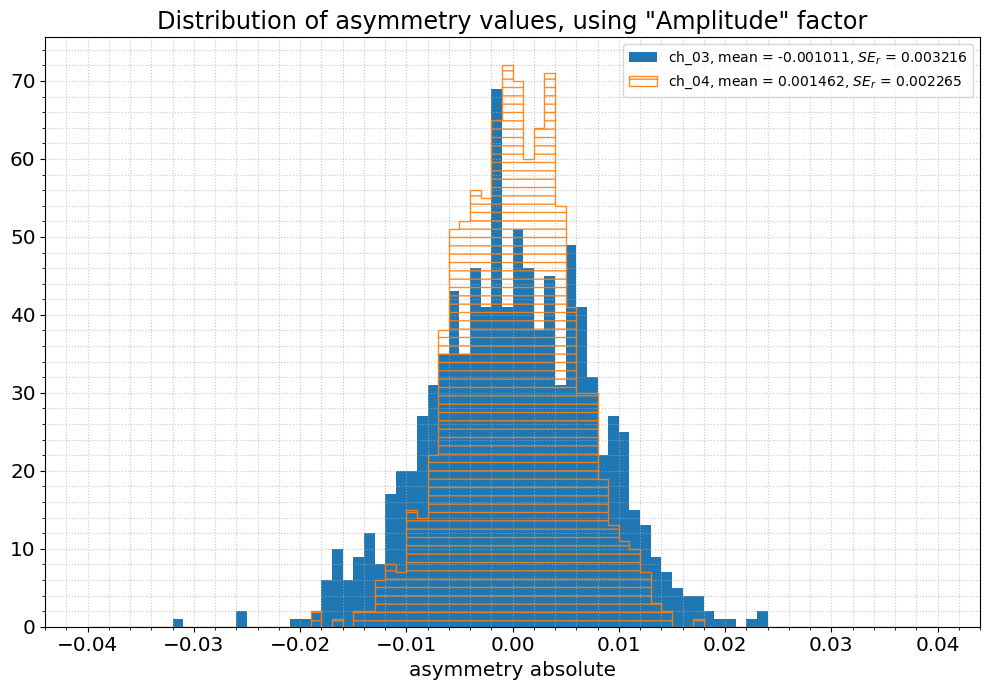

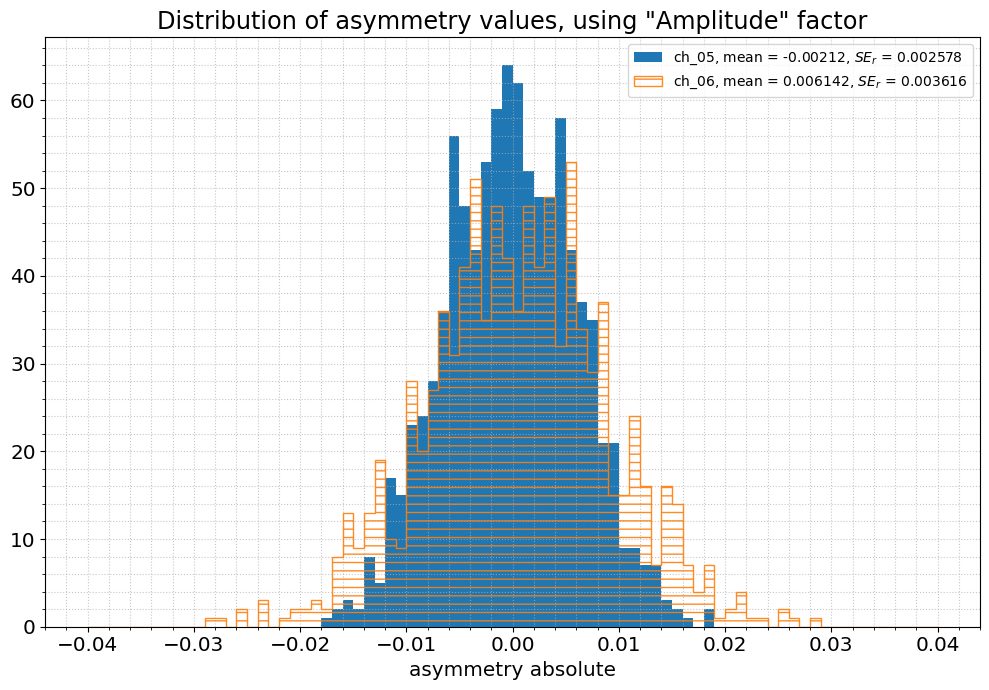

In [29]:
%matplotlib inline
# all_amp_norm = all_amp/(all_sequences) # just for hists, not for weighted avg
ch = 3
bval = 80
r = [-0.04,0.04]

plt.figure()
plt.title(rf'Distribution of asymmetry values, using "Amplitude" factor', fontsize = 'xx-large')
wmean  = np.round(mean_det_amp_r[ch],6)
wstd   = np.round(stderr_det_amp_r[ch],6)
wmean2 = np.round((mean_det_amp_r[ch+1]),6)
wstd2  = np.round((stderr_det_amp_r[ch+1]),6)
plt.hist(all_amp_norm[ch], bins =bval, range = r,  label = channels_all[ch]+f', mean = {wmean}, $SE_{{r}}$ = {wstd}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(all_amp_norm[ch+1], bins =bval, range = r, alpha =0.9, hatch='--',histtype='step', label = channels_all[ch+1]+f', mean = {wmean2}, $SE_{{r}}$ = {wstd2}')  ## all runs, ch, parameters array, sigma value
plt.xlabel('asymmetry absolute')
plt.legend(fontsize = 'medium')
plt.show()

ch = ch+2
plt.figure()
plt.title(rf'Distribution of asymmetry values, using "Amplitude" factor', fontsize = 'xx-large')
wmean  = np.round(mean_det_amp_r[ch],6)
wstd   = np.round(stderr_det_amp_r[ch],6)
wmean2 = np.round((mean_det_amp_r[ch+1]),6)
wstd2  = np.round((stderr_det_amp_r[ch+1]),6)
plt.hist(all_amp_norm[ch], bins =bval, range = r,  label = channels_all[ch]+f', mean = {wmean}, $SE_{{r}}$ = {wstd}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(all_amp_norm[ch+1], bins =bval, range = r, alpha =0.9, hatch='--',histtype='step', label = channels_all[ch+1]+f', mean = {wmean2}, $SE_{{r}}$ = {wstd2}')  ## all runs, ch, parameters array, sigma value
plt.xlabel('asymmetry absolute')
plt.legend(fontsize = 'medium')
plt.show()

In [30]:
print(numruns_tot_D)

954


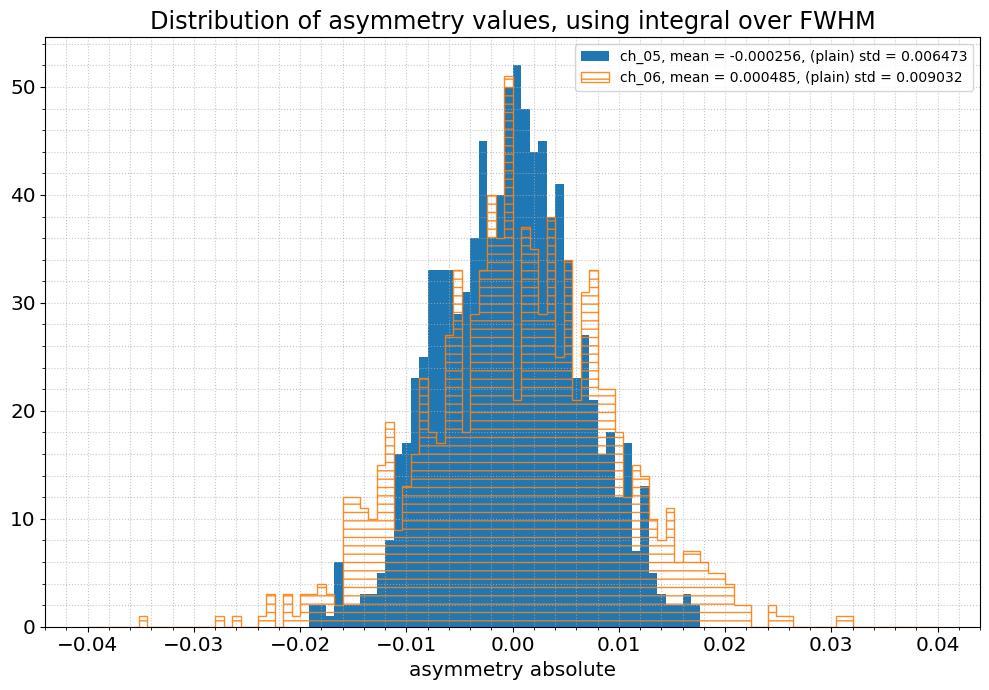

In [40]:
# ch = 8
bval = 100
r = [-0.04,0.04]
# factor = all_sequences[ch]
plt.title(rf'Distribution of asymmetry values, using integral over FWHM', fontsize = 'xx-large')
mean = np.round(np.mean(all_int_norm[ch]),6)
std = np.round(np.std(all_int_norm[ch]),6)
mean2 = np.round(np.mean(all_int_norm[ch+1]),6)
std2 = np.round(np.std(all_int_norm[ch+1]),6)

wmean  = np.round(mean_det_int_r[ch],6)
wstd   = np.round(stderr_det_int_r[ch],6)
wmean2 = np.round((mean_det_int_r[ch+1]),6)
wstd2  = np.round((stderr_det_int_r[ch+1]),6)
plt.hist(all_int_norm[ch], bins =bval, range = r,  label = channels_all[ch]+f', mean = {mean}, (plain) std = {std}')  ## all runs, ch, parameters array, sigma value
# plt.figure()
plt.hist(all_int_norm[ch+1], bins =bval, range = r, alpha =0.9, hatch='--',histtype='step', label = channels_all[ch+1]+f', mean = {mean2}, (plain) std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.xlabel('asymmetry absolute')
plt.legend(fontsize = 'medium')
plt.show()

In [41]:
# amp_integral_means = [[],[]]
# amp_integral_stds = [[],[]]

# for ch in range(0, len(all_amp)):
#     mamp = np.mean(all_amp_norm[ch])
#     samp = np.std(all_amp_norm[ch])
#     mint = np.mean(all_integral_norm[ch])
#     sint = np.std(all_integral_norm[ch])
#     amp_integral_means[0].append(mamp)
#     amp_integral_stds[0].append(samp)
#     amp_integral_means[1].append(mint)
#     amp_integral_stds[1].append(sint)

# amp_integral_means = np.asarray(amp_integral_means)
# amp_integral_stds = np.asarray(amp_integral_stds)
# mean_diffs = amp_integral_means[0]-amp_integral_means[1]
# # print(amp_integral_means[0])

# # print(amp_integral_means)

# df1 = pd.DataFrame(amp_integral_means)
# print(df1)
# print(mean_diffs)

In [42]:
print(numsequences)
print(num_seq)
print(numruns_tot_D, numruns_tot_U)
print(all_integral.shape)
print(all_amp.shape)

[np.int32(13), np.int32(13), np.int32(13)]
13
954 954
(24, 954)
(24, 954)


In [43]:
# ## all 24, amplitude / integral
# ## this is old

# %matplotlib inline
# r = [-0.04,0.04]
# b = 100

# all_NaI_amp = all_amp_norm.flatten()
# # all_NaI_amp = np.sum(all_amp_norm, axis = 0)
# # print(len(testsum))
# plt.title(rf'All 24 NaI detectors, different methods', fontsize = 'xx-large')
# mean = np.round(np.mean(all_NaI_amp),6)
# std = np.round(np.std(all_NaI_amp)/(np.sqrt(numruns_tot_D*24)),6)

# n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'Amplitude method\nmean = {mean}, (std/ $\\sqrt{{N_R*N_D}}$) = {std}')
# print(mean)
# print(np.mean(sum_ch_amp))

# all_NaI_int = all_int_norm.flatten()
# # all_NaI_int = np.sum(all_int_norm, axis = 0)
# # print(len(testsum))
# # plt.title(rf'maybe all 24 detectors using integral over FWHM', fontsize = 'xx-large')
# mean2 = np.round(np.mean(all_NaI_int),6)
# std2 = np.round(np.std(all_NaI_int)/(np.sqrt(numruns_tot_D*24)),6)

# n_int, bins_int, patches_int = plt.hist(all_NaI_int,bins=b,range=r, label = f'Integral method\nmean = {mean2}, std = {std2}', alpha =0.9, hatch='--',histtype='step')

# def gauss(x,amp,mu,sigma): # deinition of function
#     return amp*np.exp(-(x-mu)**2/2*sigma**2)

# y_amp = n_amp
# y_int = n_int
# x = np.linspace(r[0],r[1], b)

# popt_amp,pcov_amp=curve_fit(gauss,x,y_amp,p0=[100,0,2]) # popt= optimize parameter
# plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amplitude Gaussian fit mean={np.round(popt_amp[0],5)}, mu={np.round(popt_amp[1],5)}')
# popt_int,pcov_int=curve_fit(gauss,x,y_int,p0=[100,0,2]) # popt= optimize parameter
# plt.plot(x,gauss(x,*popt_int),color='orange',lw=2.0,ls = '--',label=f'Integral Gaussian fit mean={np.round(popt_int[0],5)}, mu={np.round(popt_int[1],5)}')
# # print('amp',popt[0]) # amp
# # print('meam',popt[1])# mean mu
# # print('sigma',popt[2]) # sigma


# plt.xlabel('asymmetry absolute')
# plt.legend()
# plt.show()
# print(mean2)
# # print(np.mean(sum_ch_integral))


In [44]:
## general function for reduced chi square for a given fit function. sigma is important to estimate.

def chi_square_dof(fit_func, xdata, ydata, popt, sigma=None):
    """
    Calculate chi-square and degrees of freedom for a fit.

    Parameters:
        fit_func : callable
            The model function, f(x, ...).
        xdata : array_like
            The independent variable where the data is measured.
        ydata : array_like
            The dependent data — measured values.
        popt : array_like
            Optimal values for the parameters from curve_fit.
        sigma : array_like or None
            Standard deviation errors of ydata. If None, equal weights assumed.

    Returns:
        chi2 : float
            Chi-square statistic.
        dof : int
            Degrees of freedom.
        reduced_chi2 : float
            Reduced chi-square (chi2 / dof)
    """
    yfit = fit_func(xdata, *popt)
    residuals = ydata - yfit
    if sigma is None:
        chi2 = np.sum(residuals**2)
    else:
        chi2 = np.sum((residuals / sigma)**2)
    dof = len(ydata) - len(popt)
    reduced_chi2 = chi2 / (dof)
    return residuals, chi2, dof, reduced_chi2

def gauss(x,amp,mu,sigma): # deinition of function
    return amp*np.exp(-(x-mu)**2/2*sigma**2)

chi square/dof for amp:  1.0309278350515463
amp 827.8264125695491
sigma 182.78871842821687


<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
C:\Users\gabeo\AppData\Local\Temp\ipykernel_24912\1763547336.py:24: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x,gauss(x,*popt_amp),color='red',lw=1.5,ls = '--',label=f'Amplitude Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')


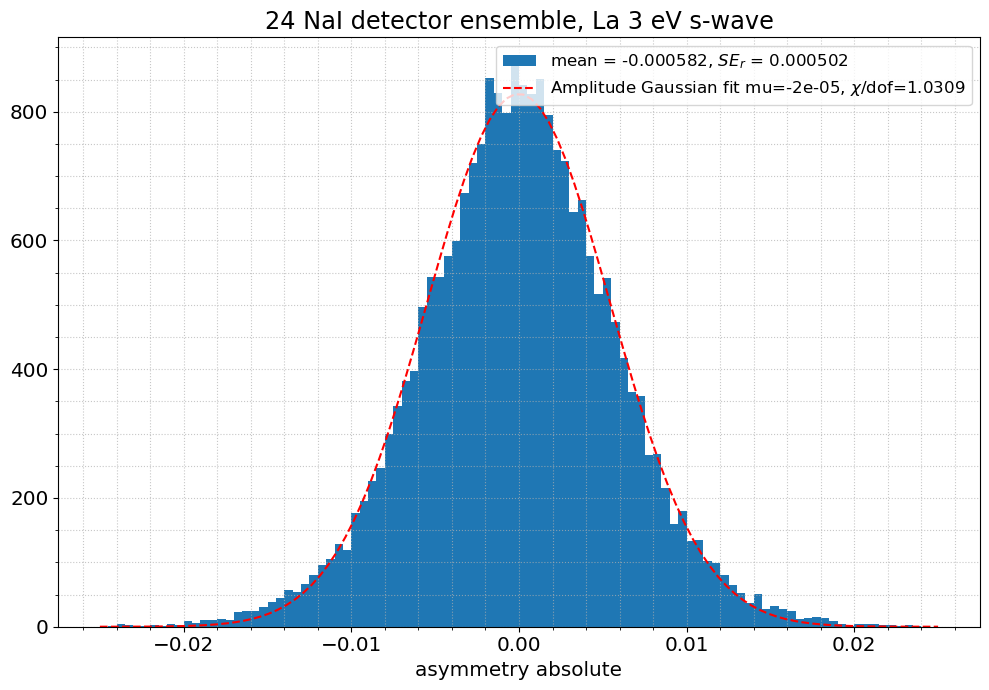

In [45]:
## all 24, amplitude different Ns --- N_seq
## redo with chisquare for gaussian fit

%matplotlib inline
r = [-0.025,0.025]
b = 100

plt.title(rf'24 NaI detector ensemble, La 3 eV s-wave', fontsize = 'xx-large')
mean = np.round(mean_all_amp_r,6)
std = np.round(se_all_amp_r,6)
n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'mean = {mean}, $SE_{{r}}$ = {std}')

y_amp = n_amp
x = np.linspace(r[0],r[1], b)

popt_amp,pcov_amp=curve_fit(gauss,x,y_amp,p0=[700,0,150]) # popt= optimize parameter
# sig = 1/np.sqrt(y_amp)
sig = gauss(x, *popt_amp) - n_amp
# sig[sig == 0] = 1
# sig = None

chi2_amp = chi_square_dof(gauss,x,y_amp, popt_amp, sig)
print('chi square/dof for amp: ', chi2_amp[-1])
plt.plot(x,gauss(x,*popt_amp),color='red',lw=1.5,ls = '--',label=f'Amplitude Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')
# plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amplitude Gaussian fit mu={np.round(popt_amp[1],5)}')

print('amp',popt_amp[0]) # amp
# print('mean',popt_amp[1], '+/-', pcov_amp.diag[1])# mean mu
print('sigma',popt_amp[2]) # sigma
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:28: SyntaxWarning: invalid escape sequence '\c'
C:\Users\gabeo\AppData\Local\Temp\ipykernel_24912\1245393062.py:28: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x,gauss(x,*popt_amp),color='red',lw=1.5,ls = '--',label=f'Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')


chi square/dof for amp:  1.0309278350515463
amp 827.8264125695491
mean -2.3485618840276155e-05
sigma 182.78871842821687


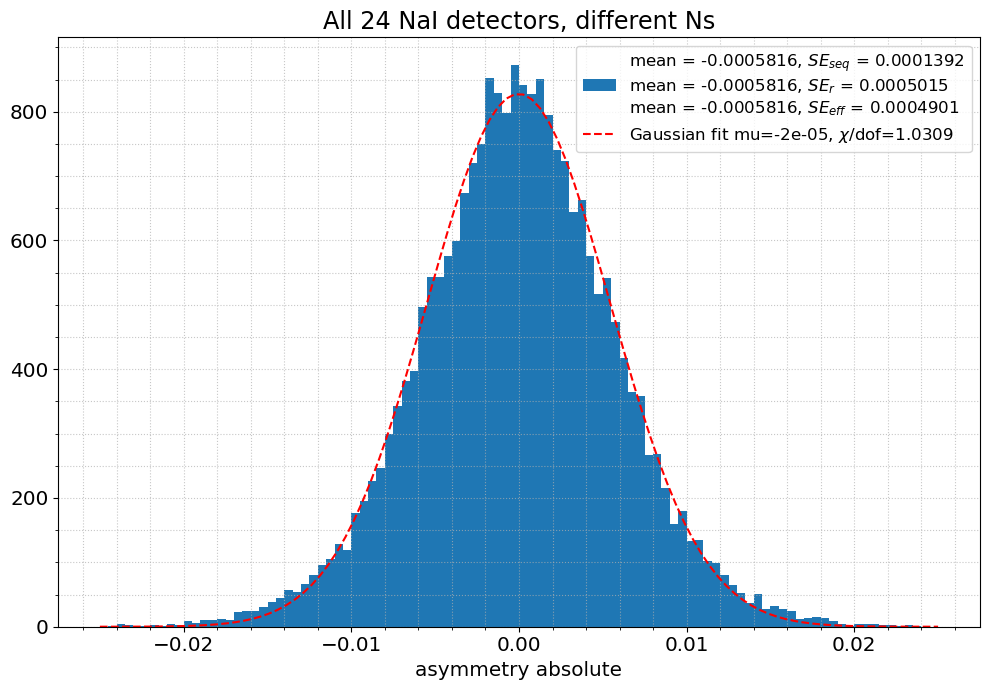

In [46]:
## all 24, amplitude different Ns --- all Ns
## redo with chisquare for gaussian fit

%matplotlib inline
r = [-0.025,0.025]
b = 100

plt.title(rf'All 24 NaI detectors, different Ns', fontsize = 'xx-large')
mean = np.round(mean_all_amp_seq,7)
std = np.round(se_all_amp_seq,7)
mean2 = np.round(mean_all_amp_r,7)
std2 = np.round(se_all_amp_r,7)
mean3 = np.round(mean_all_amp_eff,7)
std3 = np.round(se_all_amp_eff,7)
n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'mean = {mean}, $SE_{{seq}}$ = {std}\nmean = {mean2}, $SE_{{r}}$ = {std2} \nmean = {mean3}, $SE_{{eff}}$ = {std3}')

y_amp = n_amp
x = np.linspace(r[0],r[1], b)

popt_amp,pcov_amp=curve_fit(gauss,x,y_amp,p0=[700,0,150]) # popt= optimize parameter
# sig = 1/np.sqrt(y_amp)
sig = gauss(x, *popt_amp) - n_amp
# sig[sig == 0] = 1
# sig = None

chi2_amp = chi_square_dof(gauss,x,y_amp, popt_amp, sig)
print('chi square/dof for amp: ', chi2_amp[-1])
plt.plot(x,gauss(x,*popt_amp),color='red',lw=1.5,ls = '--',label=f'Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')
# plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amplitude Gaussian fit mu={np.round(popt_amp[1],5)}')

print('amp',popt_amp[0]) # amp
print('mean',popt_amp[1])# mean mu
print('sigma',popt_amp[2]) # sigma
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

In [47]:
print(mean, std)

-0.0005816 0.0001392


In [50]:
print(mean_all_amp_r)
print(mean_all_int_r)
print(se_all_amp_r, se_all_int_r)

print(mean_all_amp_r/se_all_amp_r)
print(mean_all_int_r/se_all_int_r)

-0.000581618448262583
-0.0007506302099251776
0.00050150763285797 0.0005270727014959599
-1.1597399723471424
-1.424149283001581


<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
C:\Users\gabeo\AppData\Local\Temp\ipykernel_24912\3484914381.py:40: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amp. method $\mu$ = {popt_amp[1]:.2e} $\pm$ {amp_err[1]:.2e}')
C:\Users\gabeo\AppData\Local\Temp\ipykernel_24912\3484914381.py:40: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amp. method $\mu$ = {popt_amp[1]:.2e} $\pm$ {amp_err[1]:.2e}')
C:\Users\gabeo\AppData\Local\Temp\ipykernel_24912\3484914381.py:52: SyntaxWarning: invalid escape sequ

-0.0005816
chi square/dof for amp:  1.6216014455017698
chi square/dof for int:  1.170433458591161


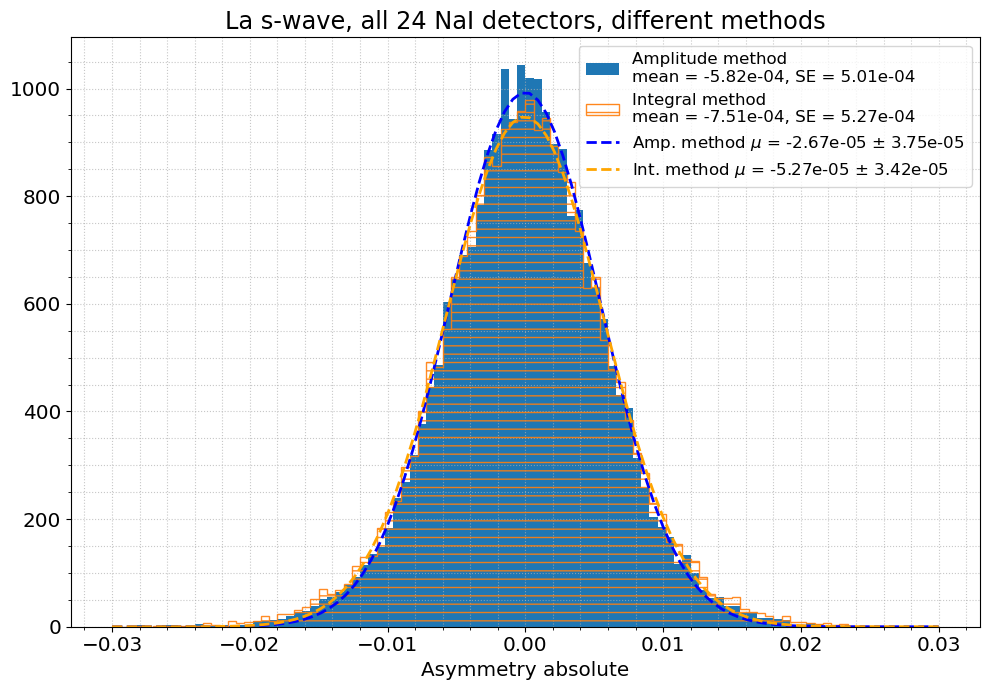

-0.0007506


In [54]:
## all 24, amplitude / integral
## redo with chisquare for gaussian fit

%matplotlib inline
r = [-0.03,0.03]
b = 100
rd = 7

plt.title(rf'La s-wave, all 24 NaI detectors, different methods', fontsize = 'xx-large')
mean = np.round(mean_all_amp_r,rd)
std = np.round(se_all_amp_r,rd)
n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'Amplitude method\nmean = {mean:.2e}, SE = {std:.2e}')
print(mean)

# plt.title(rf'maybe all 24 detectors using int over FWHM', fontsize = 'xx-large')
mean2 = np.round(mean_all_int_r,rd)
std2 = np.round(se_all_int_r,rd)

n_int, bins_int, patches_int = plt.hist(all_NaI_int,bins=b,range=r, label = f'Integral method\nmean = {mean2:.2e}, SE = {std2:.2e}', alpha =0.9, hatch='--',histtype='step')

y_amp = n_amp
y_int = n_int
x = np.linspace(r[0],r[1], b)

popt_amp,pcov_amp=curve_fit(gauss,x,y_amp,p0=[700,0,2]) # popt= optimize parameter
amp_err = np.sqrt(np.diag(pcov_amp))
# s_test = np.ones(len(y_amp))*15
# s_test = np.ones(len(y_amp))*np.mean(np.abs(chi2_amp[0]))
s_test = np.sqrt(np.mean(n_amp))
# s_test = np.sqrt(y_amp)
# s_test[s_test == 0] = 1
# print(np.std(all_NaI_amp))

# print(np.sqrt(numruns_tot_D*24))
# print(s_test)
chi2_amp = chi_square_dof(gauss,x,y_amp, popt_amp, s_test)
# print(np.mean(np.abs(chi2_amp[0])))
print('chi square/dof for amp: ', chi2_amp[-1])
# plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amplitude Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')
plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amp. method $\mu$ = {popt_amp[1]:.2e} $\pm$ {amp_err[1]:.2e}')

popt_int,pcov_int=curve_fit(gauss,x,y_int,p0=[700,0,2]) # popt= optimize parameter
int_err = np.sqrt(np.diag(pcov_int))

s_test = np.sqrt(np.mean(n_int))
# s_test = np.sqrt(y_int)
# s_test[s_test == 0] = 1
chi2_int = chi_square_dof(gauss,x,y_int, popt_int, s_test)
# print(np.mean(np.abs(chi2_int[0])))
print('chi square/dof for int: ', chi2_int[-1])
# plt.plot(x,gauss(x,*popt_int),color='orange',lw=2.0,ls = '--',label=f'Integral Gaussian fit mu={np.round(popt_int[1],5)}, $\chi$/dof={np.round(chi2_int[-1],4)}')
plt.plot(x,gauss(x,*popt_int),color='orange',lw=2.0,ls = '--',label=f'Int. method $\mu$ = {popt_int[1]:.2e} $\pm$ {int_err[1]:.2e}')

# print('amp',popt[0]) # amp
# print('meam',popt[1])# mean mu
# print('sigma',popt[2]) # sigma


plt.xlabel('Asymmetry absolute')
plt.legend()
plt.show()
print(mean2)


In [55]:
linetest = gauss(x,*popt_amp)
print(len(linetest), len(bins_amp))
linedif = linetest-bins_amp[:-1]
print(np.sqrt(np.mean(np.abs(linedif))))

linetest = gauss(x,*popt_int)
print(len(linetest), len(bins_int))
linedif = linetest-bins_int[:-1]
print(np.sqrt(np.mean(np.abs(linedif))))

print(np.sqrt(n_amp))
print(np.sqrt(n_int))

100 101
14.994492145267001
100 101
14.985425794601431
[ 0.        0.        0.        1.732051  0.        0.        2.
  2.        1.        1.        2.236068  1.        1.414214  1.732051
  1.        2.        1.732051  3.316625  3.162278  3.605551  3.741657
  4.358899  5.196152  5.385165  6.164414  7.141428  7.483315  8.062258
  8.831761  9.591663 10.723805 11.61895  12.206556 13.56466  15.459625
 16.401219 17.860571 19.390719 21.118712 22.045408 24.556058 25.436195
 26.267851 26.570661 28.       29.74895  30.248967 32.186954 30.708305
 32.295511 31.937439 31.890437 30.91925  29.949958 29.799329 27.64055
 27.838822 25.980762 25.099801 23.895606 22.       20.760539 20.174241
 17.691806 16.03122  14.282857 13.601471 12.884099 10.816654 11.575837
  9.949874  8.306624  7.28011   7.416198  6.164414  6.244998  5.09902
  5.09902   4.123106  4.123106  3.741657  3.464102  1.        2.
  2.44949   2.236068  1.414214  1.732051  1.414214  1.414214  0.
  1.        1.        1.414214  1.        0

In [56]:
print(all_sequences.shape)
print(all_amp_D.shape)

(954,)
(12, 954)


5364 5811


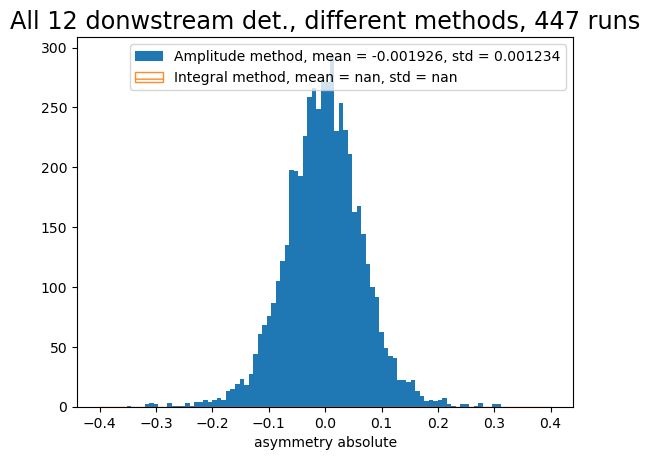

5364


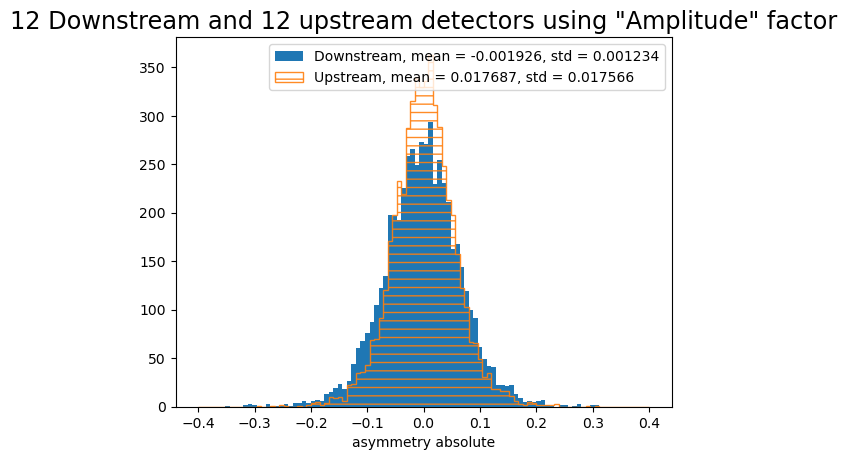

In [30]:
## upstream / downstream 

%matplotlib inline
r = [-0.4,0.4]
b = 100
all_amp_norm_D = (all_amp_D/all_sequences).flatten()
all_integral_norm_D = (all_integral_D/all_sequences).flatten()
print(len(all_amp_norm_D), len(all_integral_norm_D))
mean = np.round(np.mean(all_amp_norm_D),6)
std = np.round(np.std(all_amp_norm_D)/(np.sqrt(numruns_tot_D*12)),6)
mean2 = np.round(np.mean(all_integral_norm_D),6)
std2 = np.round(np.std(all_integral_norm_D)/(np.sqrt(numruns_tot_D*12)),6)

plt.hist(all_amp_norm_D, bins=b,range=r, label = f'Amplitude method, mean = {mean}, std = {std}')
plt.hist(all_integral_norm_D, bins=b,range=r, label = f'Integral method, mean = {mean2}, std = {std2}', alpha =0.9, hatch='--',histtype='step')
# plt.figure()
# plt.hist(all_integral_norm[ch+1], bins =bval, range = r, alpha =0.9, hatch='--',histtype='step', label = channels_all[ch+1]+f', mean = {mean2}, (plain) std = {std2}')  ## all runs, ch, parameters array, sigma value
plt.title(f'All 12 donwstream det., different methods, {numruns_tot_D} runs', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend(fontsize = 'medium')
plt.show()

plt.figure()
all_amp_norm_U = (all_amp_U/all_sequences).flatten()
print(len(all_amp_norm_U))
mean_U = np.round(np.mean(all_amp_norm_U),6)
# std = np.round(np.std(all_amp_norm_U),6)
std_U = np.round(np.std(all_amp_norm_U)/(np.sqrt(numruns_tot_U*12)),6)

# plt.hist(all_amp_norm_U, bins = b, range=r, label = rf'mean = {mean}, std = {std}')
plt.hist(all_amp_norm_D, bins=b,range=r, label = f'Downstream, mean = {mean}, std = {std}')
plt.hist(all_amp_norm_U, bins=b,range=r, label = f'Upstream, mean = {mean_U}, std = {std_U}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'12 Downstream and 12 upstream detectors using "Amplitude" factor', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

In [31]:
# print(all_amp_norm.shape)
# print(all_amp_norm[6][50:60])

# print(all_amp_norm[[0,3,6,9,12,15,18,21]][50:60])

corners = [0,3,6,9,12,15,18,21]
corner_amp_norm = np.asarray(all_amp_norm[corners])
# print(corner_amp_norm.shape)
print(all_amp_norm.shape)
print(np.delete(all_amp_norm[:],7))
print(np.delete(all_amp_norm[::],7).shape)
# print(corner_amp_norm[2][50:60])
print(all_amp_norm[:,7])

for i in range(0,24):
    # print(np.mean(all_amp_norm[i]))
    z = np.abs(stats.zscore((all_amp_norm[i])))
    # print(z)
    threshold_z = 15
    outlier_indices = np.where(z > threshold_z)[0]
    print(outlier_indices)

print(np.min(all_amp_norm[18]))

%matplotlib qt
plt.hist(all_amp_norm[18],bins=b,range=[-0.5,0.5], label = rf'Corner, mean = {mean}, plain std = {std}')
print(np.mean(all_amp_norm[18]))
print(np.std(np.delete(all_amp_norm[18],7)))

(24, 447)
[ 0.04259127 -0.04388406 -0.00810622 ...  0.06297481  0.03633653
  0.06972383]
(10727,)
[ 1.72077952e-01 -9.64309280e-03 -3.16447632e-01 -2.98861643e-01
 -1.52788439e-01  8.67919184e-01  5.74994130e-01  2.77275996e-01
  3.91866184e-02  2.78636392e-02 -6.42115496e-02  2.75511642e-02
 -1.15469681e-01  3.36181723e-02 -3.05927142e-02 -6.04406380e-02
 -6.63043955e-02  4.48612836e-02  9.41328309e+01  1.15756230e-01
  6.04633307e-02 -4.43538318e-02  4.88742699e-02 -1.92255405e-01]


NameError: name 'stats' is not defined

In [32]:
from scipy import stats
ch = 7
z = np.abs(stats.zscore(all_amp_norm[ch]))
# print(z)

threshold_z = 20

outlier_indices = np.where(z > threshold_z)[0]
print()
print(outlier_indices)
print(all_amp_norm[ch][105:115])
print(np.delete(all_amp_norm[ch], 7)[105:115])
print(all_amp_norm[ch][outlier_indices])
# no_outliers = df_diabetics.drop(outlier_indices)
# print("Original DataFrame Shape:", df_diabetics.shape)
# print("DataFrame Shape after Removing Outliers:", no_outliers.shape)


[]
[-0.00051946  0.02002275  0.01300041 -0.03327561  0.30638012 -0.02628465
  0.10813987 -0.00652395 -0.02734989  0.04759738]
[ 0.02002275  0.01300041 -0.03327561  0.30638012 -0.02628465  0.10813987
 -0.00652395 -0.02734989  0.04759738  0.00970924]
[]


In [35]:
## corner v noncorner
%matplotlib qt
r = [-0.5,0.5]
b = 100

print(len(all_amp_norm))
# corners = [0,3,6,9] ## downstream (?)
corners = [0,3,6,9,12,15,18,21]
corner_amp_norm = np.asarray(all_amp_norm[corners]).flatten()
print(all_amp_norm[corners].shape, (corner_amp_norm.shape))
mean = np.round(np.mean(corner_amp_norm),7)
std = np.round(np.std(corner_amp_norm)/(np.sqrt(numruns_tot_D*len(corners))),7) ## len of corner_amp_norm = numruns*8 (8 corner)
# std = np.round(np.std(corner_amp_norm)/(np.sqrt(len(corner_amp_norm))),6) ## len of corner_amp_norm = numruns*8 (8 corner)

plt.hist(corner_amp_norm,bins=b,range=r, label = rf'Corner, mean = {mean}, plain std = {std}')

# # noncorners = [1,2,4,5,7,8,10,11] ## downstream (?)
# noncorners = [1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23]
# noncorner_amp_norm = np.asarray(all_amp_norm[noncorners]).flatten()
# print(all_amp_norm[noncorners].shape, (noncorner_amp_norm.shape))
# # noncorner_amp_norm = noncorner_amp_norm[0].flatten()
# print(len(noncorner_amp_norm))
# mean2 = np.round(np.mean(noncorner_amp_norm),7)
# std2 = np.round(np.std(noncorner_amp_norm)/(np.sqrt(numruns_tot_D*len(noncorners))),7) 
# # std2 = np.round(np.std(noncorner_amp_norm)/(np.sqrt(len(noncorner_amp_norm))),6) 

# plt.hist(noncorner_amp_norm,bins=b,range=r, label = rf'Non-corner, mean = {mean2}, plain std = {std2}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'Corner v. Non-corner detectors', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

24
(8, 447) (3576,)


24
(8, 447) (3576,)
(8, 447) (3576,)
3576


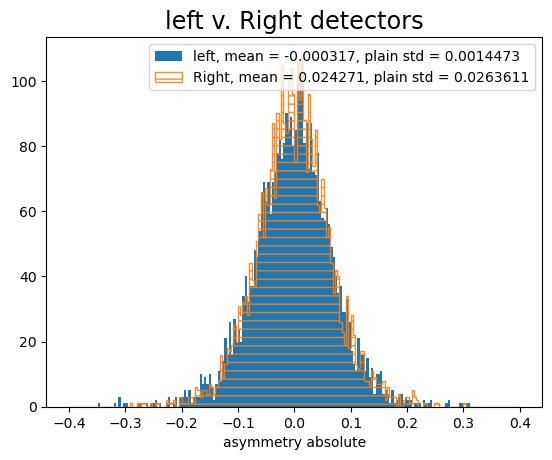

In [36]:
##left v right
## facing downstream towards beam-dump

%matplotlib inline
r = [-0.4,0.4]
b = 200

print(len(all_amp_norm))
# left = [0,3,6,9] ## downstream (?)
left = [3,4,5,6,12,23,22,21]
left_amp_norm = np.asarray(all_amp_norm[left]).flatten()
print(all_amp_norm[left].shape, (left_amp_norm.shape))
mean = np.round(np.mean(left_amp_norm),6)
std = np.round(np.std(left_amp_norm)/(np.sqrt(numruns_tot_D*8)),7) ## len of left_amp_norm = numruns*8 (8 left)
# std = np.round(np.std(left_amp_norm)/(np.sqrt(len(left_amp_norm))),6) ## len of left_amp_norm = numruns*8 (8 left)

plt.hist(left_amp_norm,bins=b,range=r, label = rf'left, mean = {mean}, plain std = {std}')

# right = [1,2,4,5,7,8,10,11] ## downstream (?)
right = [0,11,10,9,15,16,17,18]
right_amp_norm = np.asarray(all_amp_norm[right]).flatten()
print(all_amp_norm[right].shape, (right_amp_norm.shape))
# right_amp_norm = right_amp_norm[0].flatten()
print(len(right_amp_norm))
mean2 = np.round(np.mean(right_amp_norm),6)
std2 = np.round(np.std(right_amp_norm)/(np.sqrt(numruns_tot_D*8)),7) 
# std2 = np.round(np.std(right_amp_norm)/(np.sqrt(len(right_amp_norm))),6) 

plt.hist(right_amp_norm,bins=b,range=r, label = rf'Right, mean = {mean2}, plain std = {std2}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'left v. Right detectors', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

24
(8, 954) (7632,)
(8, 954) (7632,)
7632


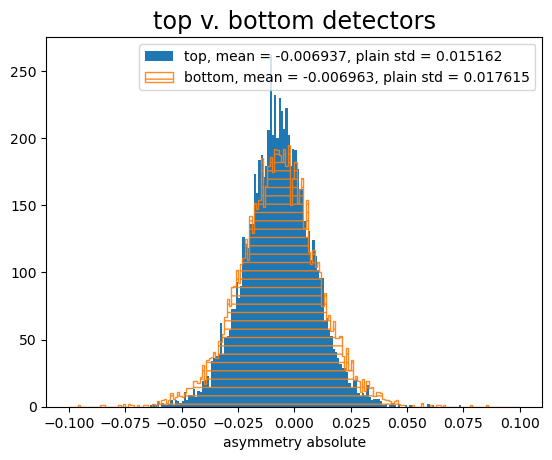

In [140]:
##top v bottom

%matplotlib inline
r = [-0.1,0.1]
b = 200

print(len(all_amp_norm))
# top = [0,3,6,9] ## downstream (?)
top = [0,1,2,3,12,13,14,15]
top_amp_norm = np.asarray(all_amp_norm[top]).flatten()
print(all_amp_norm[top].shape, (top_amp_norm.shape))
mean = np.round(np.mean(top_amp_norm),6)
std = np.round(np.std(top_amp_norm),6) ## len of top_amp_norm = numruns*8 (8 top)
# std = np.round(np.std(top_amp_norm)/(np.sqrt(len(top_amp_norm))),6) ## len of top_amp_norm = numruns*8 (8 top)

plt.hist(top_amp_norm,bins=b,range=r, label = rf'top, mean = {mean}, plain std = {std}')

# bottom = [1,2,4,5,7,8,10,11] ## downstream (?)
bottom = [6,7,8,9,18,19,20,21]
bottom_amp_norm = np.asarray(all_amp_norm[bottom]).flatten()
print(all_amp_norm[bottom].shape, (bottom_amp_norm.shape))
# bottom_amp_norm = bottom_amp_norm[0].flatten()
print(len(bottom_amp_norm))
mean2 = np.round(np.mean(bottom_amp_norm),6)
std2 = np.round(np.std(bottom_amp_norm),6) 
# std2 = np.round(np.std(bottom_amp_norm)/(np.sqrt(len(bottom_amp_norm))),6) 

plt.hist(bottom_amp_norm,bins=b,range=r, label = rf'bottom, mean = {mean2}, plain std = {std2}', alpha =0.9, hatch='--',histtype='step')

plt.title(rf'top v. bottom detectors', fontsize = 'xx-large')
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

## Now with sequence loading

##### let's re-try with amplitues per sequence instead of per run, then run autocorr

In [45]:
# import h5py
# import numpy as np
# import os

def loadrun_seq_asym(run_filename, processedpath):
    """
    Load per-sequence asymmetries from a single run file.
    Returns:
      seq_asym_per_channel: list of np.array, length = num_channels (D or U file),
                            each array length = N_seq for that run (usually 13)
    """
    run_path = os.path.join(processedpath, run_filename)
    seq_asym_per_channel = []

    with h5py.File(run_path, 'r') as f:
        channels = list(f.keys())
        numchannels = len(channels) - 1  # exclude ch_24

        for ch_name in channels:
            if ch_name == "ch_24" or ch_name == 'xs ':
                continue  # skip monitor

            ch_grp = f[ch_name]
            # Each channel has subgroups ON and OFF
            if "ON" not in ch_grp or "OFF" not in ch_grp:
                raise ValueError(f"Channel {ch_name} missing ON/OFF subgroups")

            # Extract + and - amplitudes
            A_plus = np.array(ch_grp["ON"]["parameters"])[:, 0]   # index 0 = amplitude
            A_minus = np.array(ch_grp["OFF"]["parameters"])[:, 0]

            # Compute asymmetry per sequence
            asym_seq = (A_plus - A_minus) / (A_plus + A_minus)

            seq_asym_per_channel.append(asym_seq)

    return seq_asym_per_channel


In [46]:
def build_seq_series_per_channel(d_runs, u_runs, processedpath):
    """
    Accumulates per-sequence asymmetries for all runs and channels.
    d_runs: list of filenames for downstream runs
    u_runs: list of filenames for upstream runs
    processedpath: base directory path
    Returns:
      seq_series_per_channel: list of length 24, each a 1D np.array of all sequences.
    """
    D_total = 24
    seq_series_per_channel = [[] for _ in range(D_total)]

    # Downstream detectors (0–11)
    for run_file in d_runs:
        seq_run = loadrun_seq_asym(run_file, processedpath)
        for ch in range(len(seq_run)):
            seq_series_per_channel[ch].extend(seq_run[ch])

    # Upstream detectors (12–23)
    for run_file in u_runs:
        seq_run = loadrun_seq_asym(run_file, processedpath)
        for ch in range(len(seq_run)):
            seq_series_per_channel[ch+12].extend(seq_run[ch])

    # Convert lists to numpy arrays
    seq_series_per_channel = [np.array(ch_seq) for ch_seq in seq_series_per_channel]
    return seq_series_per_channel


In [47]:
r = -20
print(foldersflat[r])
print(flatrunslist_D[r])
print(foldersflat[r] + flatrunslist_D[r])
print(processed_path +foldersflat[r] + flatrunslist_D[r])
test = foldersflat+flatrunslist_D
print(test[r])
test2 = np.char.add(foldersflat,'asym_swave_D/')
print(test2[r])

runs12034-12363/
12344_swave_D.h5
runs12034-12363/12344_swave_D.h5


NameError: name 'processed_path' is not defined

In [48]:
# Example lists of filenames (you already have flatrunslist_D / _U)
d_run_files = np.char.add(foldersflat,'asym_swave_D/')+flatrunslist_D
u_run_files = np.char.add(foldersflat,'asym_swave_U/')+flatrunslist_U
processed_path = root + processedfolder  # same base path you already use

seq_series_per_channel = build_seq_series_per_channel(
    d_run_files, u_run_files, processed_path
)

# Inspect the shape
for d, arr in enumerate(seq_series_per_channel):
    print(f"Detector {d}: shape {arr.shape}")
seq_series_per_channel = np.array(seq_series_per_channel)

Detector 0: shape (8266,)
Detector 1: shape (8266,)
Detector 2: shape (8266,)
Detector 3: shape (8266,)
Detector 4: shape (8266,)
Detector 5: shape (8266,)
Detector 6: shape (8266,)
Detector 7: shape (8266,)
Detector 8: shape (8266,)
Detector 9: shape (8266,)
Detector 10: shape (8266,)
Detector 11: shape (8266,)
Detector 12: shape (8266,)
Detector 13: shape (8266,)
Detector 14: shape (8266,)
Detector 15: shape (8266,)
Detector 16: shape (8266,)
Detector 17: shape (8266,)
Detector 18: shape (8266,)
Detector 19: shape (8266,)
Detector 20: shape (8266,)
Detector 21: shape (8266,)
Detector 22: shape (8266,)
Detector 23: shape (8266,)


In [49]:
## now that it is shown that autocor is 0 for sequences, do an equivalent asym, but with weights of 1, because we have individual asymm

def w_asym(asym_array, weights=None, N_input=None):
    # Handle 1D detector input
    single_channel = False
    if asym_array.ndim == 1:
        single_channel = True
        asym_array = asym_array[None, :]  # shape (1, M)

    D, M = asym_array.shape  # detectors × measurements

    # Default: equal weights = 1
    if weights is None:
        weights = np.ones(M)
    weights = np.asarray(weights, dtype=float)

    # Normalize and totals
    N_s = np.sum(weights)
    N_tot = D * N_input if N_input is not None else D * N_s

    # Weighted mean per detector
    weighted_sum = np.sum(asym_array * weights[None, :], axis=1)
    mu_det = weighted_sum / N_s

    # Weighted variance per detector
    resid = asym_array - mu_det[:, None]
    S_d = np.sum(weights[None, :] * resid**2, axis=1)
    sigma2_d = S_d / N_s
    se_det = np.sqrt(sigma2_d / N_input) if N_input else np.sqrt(sigma2_d / N_s)

    if single_channel:
        return mu_det[0], se_det[0]

    # Combined (ensemble) mean and SE
    mu_total = np.sum(weighted_sum) / (D * N_s)
    resid_total = asym_array - mu_total
    S_total = np.sum(weights[None, :] * resid_total**2)
    sigma2_total = S_total / (D * N_s)
    se_total = np.sqrt(sigma2_total / N_tot)
    return mu_total, se_total


In [53]:

# -------------- load data --------------
Nr = np.asarray(all_sequences, dtype =np.int32)   # shape (R,)
A = all_amp  # shape (D, R)
print(type(Nr[0]), type(A[0][0]))
D, R = A.shape
N_seq = int(Nr.sum())

# choose detector (zero-based index)
det = 5

# -------------- flatten per-sequence series --------------
per_run = A[det]                # length R
run_series = all_amp[det]

# -------------- autocorr estimator (normalized) --------------
def autocorr_rho_full(x, max_lag=None):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if max_lag is None or max_lag > n-1:
        max_lag = n-1
    xm = x - x.mean()
    denom = np.sum(xm * xm)
    corr_full = np.correlate(xm, xm, mode='full')
    corr = corr_full[n-1:n+max_lag+1]    # lags 0..max_lag
    rho = corr / denom
    return rho  # rho[0] = 1

max_lag = min(2000, N_seq-1)
# rho = autocorr_rho_full(run_series, max_lag=max_lag)
rho = autocorr_rho_full(seq_series_per_channel[det], max_lag=max_lag) ## uses all sequences individually organized

# -------------- cutoff rule (first negative or below noise) --------------
noise_level = 2.0 / math.sqrt(N_seq)
cutoff = max_lag
for k in range(1, len(rho)):
    if rho[k] < 0 or rho[k] < noise_level:
        cutoff = k-1
        break

# -------------- tau, Neff --------------
if cutoff >= 1:
    tau_sum = 1.0 + 2.0 * np.sum(rho[1:cutoff+1])
else:
    tau_sum = 1.0
Neff_sum = N_seq / tau_sum if tau_sum > 0 else 1.0
# Neff_sum = R / tau_sum if tau_sum > 0 else 1.0


# -------------- weighted std and SEs --------------
# weighted mean per-run for this detector:
# mu = np.average(per_run, weights=Nr)
mu, se = w_asym(seq_series_per_channel[det], weights=np.ones(seq_series_per_channel.shape[1]), N_input=seq_series_per_channel.shape[1])
var_w = np.sum(Nr * (per_run - mu)**2) / N_seq
sigma_w = math.sqrt(var_w)

SE_seq = sigma_w / math.sqrt(N_seq)
SE_run = sigma_w / math.sqrt(R)
SE_neff = sigma_w / math.sqrt(Neff_sum)

# -------------- print results --------------
print("Detector:", det)
print("R (runs):", R)
print("N_seq (per detector):", N_seq)
print("rho1:", rho[1])
print("noise_level (2/sqrt(N)):", noise_level)
print("cutoff lag:", cutoff)
print("tau_sum (truncated):", tau_sum)
print("N_eff (truncated):", Neff_sum)
print(f'mu (weighted per-run mean): {mu:.7f}')
print("sigma_w (weighted std):", sigma_w)
print("SE_seq:", SE_seq)
print("SE_run:", SE_run)
print("SE_neff:", SE_neff)

# -------------- plot rho_k --------------
lags = np.arange(len(rho))
plt.figure(figsize=(9,3))
plt.plot(lags[:200], rho[:200], marker='.', markersize=4, linestyle='-')
# plt.axhline(noise_level, color='red', linestyle='--', label=f'noise level = {noise_level:.4f}')
plt.axhline(0, color='red', linestyle='--', label=r'$\hat\rho_k$ 0 level')
plt.axvline(cutoff, color='green', linestyle='--', label=f'cutoff = {cutoff}')
plt.xlabel('lag k')
plt.ylabel(r'$\hat\rho_k$')
plt.title(f'Autocorrelation $\hat\\rho_k$, det. {det}, {N_seq} individual sequences')
plt.xlim(-2, 30)
plt.legend()

# Create a text box next to the legend
textstr = f'$\\tau_{{sum}}$ = {tau_sum:.2f}\n$N_{{eff}}$ = {Neff_sum:.0f}'

# Get the legend box position
leg = plt.gca().get_legend()
if leg:
    bbox = leg.get_frame().get_bbox()
    x0 = bbox.x1 - 0.05  # small offset to the right of legend
    y0 = bbox.y0 + 0.05
else:
    x0, y0 = 0.8, 0.8  # fallback position

# Place the annotation box
plt.gca().text(0.8, 0.9, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='whitesmoke', alpha=0.8))

plt.tight_layout()
plt.show()

<class 'numpy.int32'> <class 'numpy.float64'>
Detector: 5
R (runs): 636
N_seq (per detector): 8266
rho1: 0.0005029415078831388
noise_level (2/sqrt(N)): 0.021997954285372767
cutoff lag: 0
tau_sum (truncated): 1.0
N_eff (truncated): 8266.0
mu (weighted per-run mean): -0.0002133
sigma_w (weighted std): 0.07506442107825796
SE_seq: 0.0008256318516687452
SE_run: 0.002976497908356348
SE_neff: 0.0008256318516687452


<>:84: SyntaxWarning: invalid escape sequence '\h'
<>:84: SyntaxWarning: invalid escape sequence '\h'
C:\Users\gabeo\AppData\Local\Temp\ipykernel_29748\1125879832.py:84: SyntaxWarning: invalid escape sequence '\h'
  plt.title(f'Autocorrelation $\hat\\rho_k$, det. {det}, {N_seq} individual sequences')


In [54]:
print('1. using old [DxR] array of asymmetries with all_sequences weights (Num. of sequences length R) and N=N_seq:')
mu_old, se_old = w_asym(all_amp, weights=all_sequences, N_input=np.sum(all_sequences))
print(mu_old, '+/-', se_old, '\n')
print('2. using old [DxR] array of asymmetries with all_sequences weights (Num. of sequences length R) and N=N_r:')
mu_old, se_old = w_asym(all_amp, weights=all_sequences, N_input=N_r)
print(mu_old, '+/-', se_old, '\n')
print('3. using new [DxS] of asymmetries array with equal weights of 1 and N=N_seq:')
seq_series_per_channel = np.array(seq_series_per_channel)
mu, se = w_asym(seq_series_per_channel, weights=np.ones(seq_series_per_channel.shape[1]), N_input=seq_series_per_channel.shape[1])
print(mu, '+/-', se)

1. using old [DxR] array of asymmetries with all_sequences weights (Num. of sequences length R) and N=N_seq:
-0.0007965134153713967 +/- 0.00016826189389083912 

2. using old [DxR] array of asymmetries with all_sequences weights (Num. of sequences length R) and N=N_r:
-0.0007965134153713967 +/- 0.0006066035051941051 

3. using new [DxS] of asymmetries array with equal weights of 1 and N=N_seq:
-6.152599298447422e-05 +/- 4.6942171798302234e-05


In [55]:
mean_all_r, se_all_r = w_asym(all_amp, weights=all_sequences, N_input=N_r)
print(mean_all_r, se_all_r, '\n')
mean_all_seq_new, se_all_seq_new = w_asym(seq_series_per_channel, weights=np.ones(seq_series_per_channel.shape[1]), N_input=seq_series_per_channel.shape[1])
print(mean_all_seq_new, se_all_seq_new, '\n')


-0.0007965134153713967 0.0006066035051941051 

-6.152599298447422e-05 4.6942171798302234e-05 



In [68]:
## all 24, amplitude separated into sequencces

%matplotlib qt
r = [-0.025,0.025]
b = 100

mu, se = w_asym(seq_series_per_channel, weights=np.ones(seq_series_per_channel.shape[1]), N_input=seq_series_per_channel.shape[1])

all_NaI_amp = all_amp_norm.flatten()
plt.title(rf'All 24 NaI detectors, organization by sequences', fontsize = 'xx-large')
mean = np.round(mu,7)
std = np.round(se,7)
mean2 = np.round(mean_all_r,7)
std2 = np.round(se_all_r,7)
# mean3 = np.round(mean_all_eff,7)
# std3 = np.round(se_all_eff,7)
# n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'mean = {mean}, $SE_{{seq}}$ = {std}\nmean = {mean2}, $SE_{{r}}$ = {std2} \nmean = {mean3}, $SE_{{eff}}$ = {std3}')
n_amp, bins_amp, patches_amp = plt.hist(all_NaI_amp,bins=b,range=r, label = f'mean = {mean}, $SE_{{seq}}$ = {std}\nmean = {mean2}, $SE_{{r}}$ = {std2}')

y_amp = n_amp
x = np.linspace(r[0],r[1], b)

popt_amp,pcov_amp=curve_fit(gauss,x,y_amp,p0=[700,0,150]) # popt= optimize parameter
# sig = 1/np.sqrt(y_amp)
sig = gauss(x, *popt_amp) - n_amp
# sig[sig == 0] = 1
# sig = None

chi2_amp = chi_square_dof(gauss,x,y_amp, popt_amp, sig)
print('chi square/dof for amp: ', chi2_amp[-1])
plt.plot(x,gauss(x,*popt_amp),color='red',lw=1.5,ls = '--',label=f'Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')
# plt.plot(x,gauss(x,*popt_amp),color='blue',lw=2.0,ls = '--',label=f'Amplitude Gaussian fit mu={np.round(popt_amp[1],5)}')

print('amp',popt_amp[0]) # amp
print('mean',popt_amp[1])# mean mu
print('sigma',popt_amp[2]) # sigma
plt.xlabel('asymmetry absolute')
plt.legend()
plt.show()

chi square/dof for amp:  1.0309278350515463
amp 557.3767726991275
mean -4.114811640335349e-05
sigma 184.23269118287558


<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
C:\Users\gabeo\AppData\Local\Temp\ipykernel_29748\743496949.py:31: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x,gauss(x,*popt_amp),color='red',lw=1.5,ls = '--',label=f'Gaussian fit mu={np.round(popt_amp[1],5)}, $\chi$/dof={np.round(chi2_amp[-1],4)}')


In [66]:
print(np.abs(mu/se))
print(np.abs(mean2/std2))

1.3106763199801386
1.3130563798219586


In [136]:
print(seq_series_per_channel.shape)

(24, 8266)


# ended here

#### original testing with weighted means, SE, etc.

In [ ]:
## according to mr. GPT

A = np.array(all_amp[1])          # your run sums (asymmetries)
n = np.array(all_sequences)          # your run sizes (sequences), e.g. mostly 13

K = len(A)
Ntot = n.sum()

m = A / n                # per-run mean per sequence
mu = A.sum() / Ntot      # weighted grand mean (per-sequence)

S = np.sum(n * (m - mu)**2)     # sum n_i*(m_i - mu)^2
sigma2_hat = S / (K - 1)        # unbiased estimator of per-sequence variance
SE_mu = np.sqrt(sigma2_hat / Ntot)

print("K =", K, "Ntot =", Ntot)
print("mu = {:.6e} ± {:.6e}".format(mu, SE_mu))

In [ ]:
# Suppose you have M=24 detectors, per-detector run-sums A_k_runs (shape M x K)
# and run sizes n_runs (length K). We compute per-detector per-seq variance sigma2_k,
# then a pooled sigma2_pooled and SE_combined assuming independence.

M = 24
A = all_amp   # shape (M, K) run sums per detector
n_runs = all_sequences  # shape (K,), sequences in each run (same for all detectors)

# per-detector grand mean and per-run means:
N_per_detector = n_runs.sum()           # this is your 'n' above
mk_runs = A / n_runs                    # shape (M, K)
mk = A.sum(axis=1) / N_per_detector     # per-detector weighted mean

# estimate per-detector per-sequence variance from run-compressed data
K = A.shape[1]
sigma2_k = np.zeros(M)
for k in range(M):
    mi = mk_runs[k, :]
    S = np.sum(n_runs * (mi - mk[k])**2)
    sigma2_k[k] = S / (K - 1)    # unbiased per-sequence var estimate for detector k

# pooled variance (if you assume detectors share same sigma^2)
sigma2_pooled = sigma2_k.mean()    # or a weighted average if preferred

# combined SE assuming detectors independent:
SE_combined = np.sqrt(sigma2_pooled / (N_per_detector * M))

# If you suspect correlations, compute empirical covariance of mk_runs across detectors
# and use Var(combined_mean) = (1/M^2) * 1^T Cov(mk) 1  (see earlier messages)

print(np.mean(A.flatten()))
print(sigma2_pooled, SE_combined)

In [26]:
## from chat
D, R = all_amp.shape

# Weighted mean per detector
w_mean_det_amp = np.sum(all_amp * all_sequences, axis=1) / np.sum(all_sequences)
w_mean_det_integral = np.sum(all_integral * all_sequences, axis=1) / np.sum(all_sequences)

# Weighted standard deviation per detector
w_var_det_amp = np.sum(all_sequences * (all_amp - w_mean_det_amp[:, None])**2, axis=1) / np.sum(all_sequences)
w_std_det_amp = np.sqrt(w_var_det_amp)  ## I think because the std is weighted, we can use SE for runs, i.e. /sqrt(R), because /sqrt(N) is already accounted for
# stderr_det_amp = w_std_det_amp / np.sqrt(len(all_sequences))  ## this assumes N_r runs
stderr_det_amp = w_std_det_amp / np.sqrt(np.sum(all_sequences))  ## this uses N_seq all sequences
print(w_mean_det_amp.shape, stderr_det_amp.shape)

w_var_det_integral = np.sum(all_sequences * (all_integral - w_mean_det_integral[:, None])**2, axis=1) / np.sum(all_sequences)
w_std_det_integral = np.sqrt(w_var_det_integral)
stderr_det_integral = w_std_det_integral / np.sqrt(len(all_sequences))
print(w_mean_det_integral.shape, stderr_det_integral.shape)

# Combined weighted mean (all detectors)
w_mean_all_amp = np.sum(all_amp * all_sequences) / (np.sum(all_sequences)*D)
w_var_all_amp = np.sum(all_sequences * (all_amp - w_mean_all_amp)**2) / (np.sum(all_sequences) * all_amp.shape[0])
w_std_all_amp = np.sqrt(w_var_all_amp)
# stderr_all_amp = w_std_all_amp / np.sqrt(all_amp.size) ## this assumes N_r runs
stderr_all_amp = w_std_all_amp / np.sqrt(np.sum(all_sequences)*all_amp.shape[0]) ## this uses N_seq all sequences

w_mean_all_integral = np.sum(all_integral * all_sequences) / np.sum(all_sequences)
w_var_all_integral = np.sum(all_sequences * (all_integral - w_mean_all_integral)**2) / np.sum(all_sequences)
w_std_all_integral = np.sqrt(w_var_all_integral)
stderr_all_integral = w_std_all_integral / np.sqrt(all_integral.size)

print(f"Weighted mean per detector: {w_mean_det_amp}")
print(f"Combined asymmetry (all 24 dets): {w_mean_all_amp:.6f} ± {stderr_all_amp:.6f}")
print(w_mean_det_amp.shape, stderr_det_amp.shape)
print(w_mean_all_amp.shape, stderr_all_amp.shape)

print(f"Weighted mean per detector: {w_mean_det_integral}")
print(f"Combined asymmetry (all 24 dets): {w_mean_all_integral:.6f} ± {stderr_all_integral:.6f}")
print(w_mean_det_integral.shape, stderr_det_integral.shape)
print(w_mean_all_integral.shape, stderr_all_integral.shape)


(24,) (24,)
(24,) (24,)
Weighted mean per detector: [-0.002511 -0.001633  0.000386 -0.001494 -0.001146 -0.002758  0.004615
  0.005249 -0.002404 -0.006081 -0.001498 -0.000962  0.000315  0.001566
 -0.003329 -0.006644  0.000311 -0.002174  0.00075   0.000206 -0.000939
 -0.004652  0.005202  0.000507]
Combined asymmetry (all 24 dets): -0.000797 ± 0.000168
(24,) (24,)
() ()
Weighted mean per detector: [-0.004409 -0.001833  0.001514 -0.002572 -0.001141 -0.004163  0.004925
  0.003671 -0.002695 -0.004924 -0.002698 -0.00027   0.00039   0.001895
 -0.00362  -0.006858  0.00001  -0.001463 -0.001826 -0.000961 -0.001231
 -0.002945  0.004485  0.000367]
Combined asymmetry (all 24 dets): -0.026353 ± 0.003273
(24,) (24,)
() ()


In [ ]:
# # Create sample arrays
# array1 = all_sequences
# array2 = all_amp

# # Save the arrays to an uncompressed .npz file
# np.savez('asym_all_detectors.npz', arr1=array1, arr2=array2)


#### testing

8992


(-0.01, 4.0)

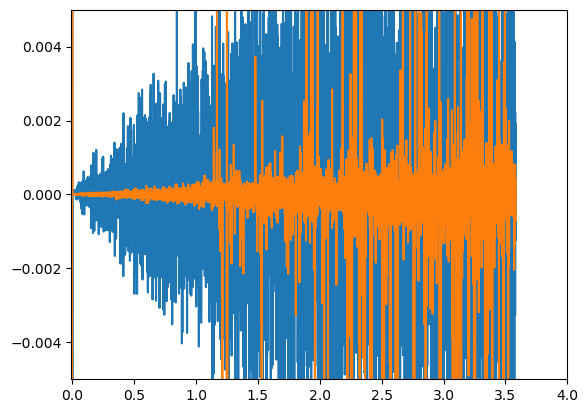

In [46]:
## what it looked like previous to deleting runs

allNaI_raw = np.sum(sum_ch_raw[3:5], axis = 0)
%matplotlib inline
print(len(allNaI_raw))
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.005, 0.005)
plt.xlim(-0.01, 4.0)

-0.07288897630071575


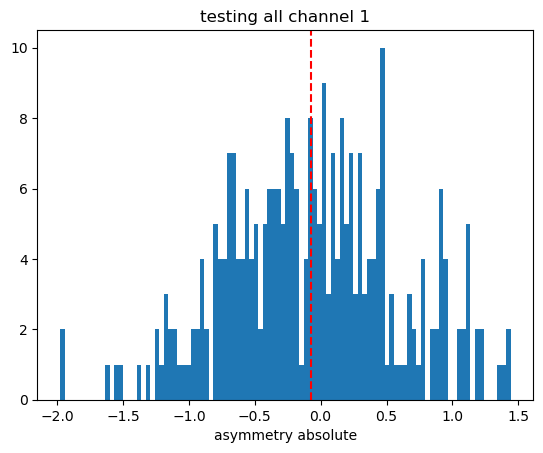

In [37]:
## idk what this is...

%matplotlib inline
ch = 1
plt.hist(all_amp[ch], bins = 100)
chmean = np.mean(all_amp[ch])
print(chmean)
plt.axvline(x=chmean,ls='--', c ='r')

plt.xlabel('asymmetry absolute')
plt.ylabel('')
plt.title(f'testing all channel {ch}')
# plt.legend()
plt.show()

In [31]:
# ## previously used for checking vstack

# %matplotlib inline
# # all_raw = np.vstack((all_raw_D,all_raw_U))
# # all_amp = np.vstack((all_amp_D,all_amp_U))
# # all_amp_norm = all_amp/all_sequences

# # plt.plot(xs, all_raw_D[-1][20])
# # plt.plot(xs, all_raw[11][20])
# plt.plot(xs, all_raw_U[-1][20])
# plt.plot(xs, all_raw[-1][20])
# plt.ylim(-100, 100)
# plt.xlim(-0.01, 3)
# # print(len(all_raw_D[0]))
# for i in range(0,12):
#     if all_raw_U[i][20][50] == all_raw[i+12][20][50]:
#         print('yay')
#     if all_raw_D[i][20][50] == all_raw[i][20][50]:
#         print('yay 2')
#     else: 
#         print('boo')
# # testrans = np.asarray(all_raw_D.transpose(1,0,2))
# # testranssum = np.sum(testrans[ch,:], axis = 0)
# # plt.plot(xs, testranssum)

In [ ]:
## testing for outlier runs
# ch = 0
# for ch in range(0, 1):
problem_files = [[],[]]
outlier_thresh = 50
start_b = 2300

for ch in range(0, len(all_raw_U)):
# for ch in range(0, 2):
    # plt.figure()
    for i in range(0, len(all_raw_U[0])):
        if np.max(np.abs(all_raw_U[ch,i,start_b:])) >= outlier_thresh:
            problem_files[0].append(ch)
            problem_files[1].append(i) 
            # print(ch, i, np.max(all_raw_U[ch,i,2200:]))
            plt.plot(all_raw_U[ch,i])

plt.axvline(start_b, ls = '--')
plt.axhline(outlier_thresh, ls = '--')
plt.show()
print(problem_files)
print(np.unique(np.sort(problem_files[1])))

print(all_raw_U.shape)
test_del = all_raw_U.copy()
test_prob_f = np.unique(np.sort(problem_files[1]))
print(test_prob_f)
print(len(test_prob_f))
test_new = np.delete(test_del, test_prob_f, axis=1)

print(test_new.shape)

%matplotlib qt
p = 0
plt.plot(all_raw_U[0][p], label='og')
plt.plot(all_raw_U[0][p+1], label = 'og+1', ls ='-.')
plt.plot(test_new[0][p], label = 'test del p ', ls ='--')
plt.plot(test_new[0][p+1], label = 'test del p+1', ls ='--')

plt.ylim(-100, 100)
plt.legend()

# print(all_raw_U[0][0][2200:2205])
# print(all_raw_U[0,0:p+6,2200:2205])
# # print(all_raw_U[0][p-1][2200:2205])
# # print(all_raw_U[0][p][2200:2205])
# # print(all_raw_U[0][p+1][2200:2205])
# # print(all_raw_U[0][p+2][2200:2205])
# # print(all_raw_U[0][p+3][2200:2205])
# # print(all_raw_U[0][p+4][2200:2205])
# print()
# # print(test_new[0][p-2][2200:2205])
# # print(test_new[0][p-1][2200:2205])
# # print(test_new[0][p][2200:2205])
# # print(test_new[0][p+1][2200:2205])
# # print(test_new[0][p+2][2200:2205])
# # print(test_new[0][p+3][2200:2205])
# # print(test_new[0][p+4][2200:2205])
# print(test_new[0,0:p+4,2200:2205])

sum_ch_raw = []
sum_ch_amp = []
p1 = 300
p2 = 400
for ch in range(0, len(all_raw)):
    chraw = np.sum(all_raw[ch,p1:p2], axis = 0)
    sum_ch_raw.append(chraw)
for ch in range(0, len(all_amp)):
    champ = np.sum(all_amp[ch,p1:p2], axis = 0)
    sum_ch_amp.append(champ)

sum_ch_raw = np.array(sum_ch_raw)
    
sum_ch_amp = sum_ch_amp/np.sum(all_sequences) ## normalize sum of amplitudes!
    
print(len(sum_ch_raw), len(sum_ch_amp))
print(len(sum_ch_raw[0]))
allNaI_raw = np.sum(sum_ch_raw[0:23], axis = 0)

%matplotlib qt
print(len(allNaI_raw))
plt.plot(xs, sum_ch_raw[2]/np.sum(all_sequences))
# plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.02, 0.02)
plt.xlim(-0.01, 3.5)
# print(len(all_raw_D[0]))
print(sum_ch_amp)

### paper plotting

# only run once!

24 24
8992
8992


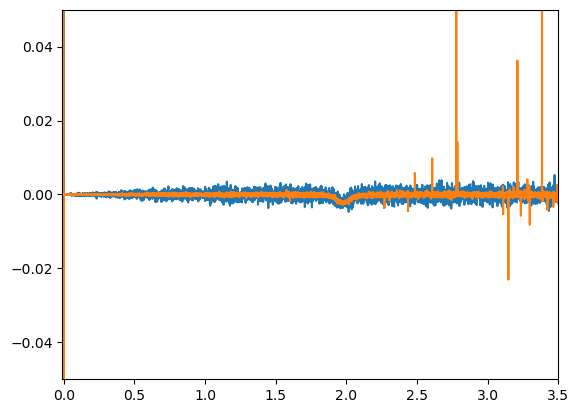

(24, 954, 8992)
deleted a run 109. New shape:  (24, 953, 8992)
New added D/U pulses shape:  (13, 953, 8992) (13, 953, 8992)
24 24
8992
8992


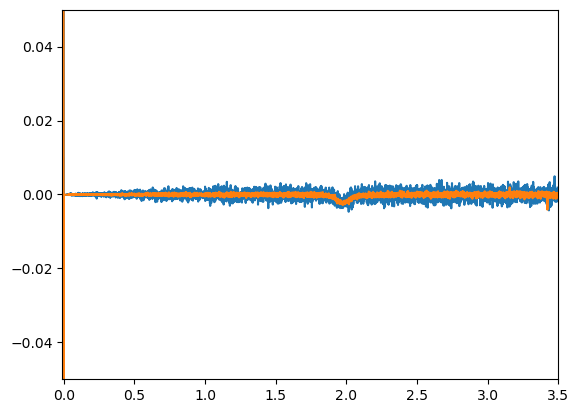

In [32]:
## Testing deleting a specific troublesome run

sum_ch_raw = []
sum_ch_amp = []
for ch in range(0, len(all_raw)):
    chraw = np.sum(all_raw[ch,:], axis = 0)
    champ = np.sum(all_amp[ch,:], axis = 0)
    sum_ch_raw.append(chraw)
    sum_ch_amp.append(champ)

    
sum_ch_amp = sum_ch_amp/np.sum(all_sequences) ## normalize sum of amplitudes!
    
print(len(sum_ch_raw), len(sum_ch_amp))
print(len(sum_ch_raw[0]))

allNaI_raw = np.sum(sum_ch_raw[:], axis = 0)
print(len(allNaI_raw))

plt.figure()
%matplotlib inline
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.05, 0.05)
plt.xlim(-0.01, 3.5)
plt.show()
# print(len(all_raw_D[0]))
# print(sum_ch_amp)

#############################################################################
if folders_start == 'runs11727-12033':
    tb = 109
    print(all_raw.shape)
    all_raw = np.delete(all_raw, tb,1)
    all_D = np.delete(all_D, tb,1)
    all_U = np.delete(all_U, tb,1)
    print(f'deleted a run {tb}. New shape: ', all_raw.shape)
    print(f'New added D/U pulses shape: ', all_D.shape, all_U.shape)
else:
    print('No runs deleted. Shape: ', all_raw.shape)
    print(f'D/U pulses shape: ', all_D.shape, all_U.shape)
    
#############################################################################
sum_ch_raw = []
sum_ch_amp = []
for ch in range(0, len(all_raw)):
    chraw = np.sum(all_raw[ch,:], axis = 0)
    champ = np.sum(all_amp[ch,:], axis = 0)
    sum_ch_raw.append(chraw)
    sum_ch_amp.append(champ)

    
sum_ch_amp = sum_ch_amp/np.sum(all_sequences) ## normalize sum of amplitudes!
    
print(len(sum_ch_raw), len(sum_ch_amp))
print(len(sum_ch_raw[0]))

allNaI_raw = np.sum(sum_ch_raw[:], axis = 0)
print(len(allNaI_raw))

plt.figure()
plt.plot(xs, sum_ch_raw[1]/np.sum(all_sequences))
plt.plot(xs, allNaI_raw/np.sum(all_sequences)/24)
plt.ylim(-0.05, 0.05)
plt.xlim(-0.01, 3.5)
plt.show()
# print(len(all_raw_D[0]))


### plotting for paper

In [33]:
from functools import reduce
def factors(n):
    return set(reduce(list.__add__,([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

# rebinf = rebinfactors[6]
# print(f'using factor {rebinf}')
# y2_rebin, x_rebin = rebin(y2, x, rebinf)


In [41]:
pulseadd_D = np.sum(all_D[:], axis = 1)

# Sample data
# r = 550
r1 = 2001
r2 = 8501

ch = 1
x = xs[r1:r2]
y1 = pulseadd_D[ch][r1:r2]
# y2 = allNaI_raw[r1:r2]/np.sum(all_sequences)/24*-1 ## flip the sign for plotting
y2 = sum_ch_raw[ch][r1:r2]/np.sum(all_sequences)*-1 ## flip the sign for plotting

rebinfactors = np.sort(np.array(list(factors(len(y2)))))
print(f'possible factors are ', rebinfactors)

rebinf = rebinfactors[5]
print(f'using factor {rebinf}')

y2_rebin, x_rebin = rebin(y2, x, rebinf)

possible factors are  [   1    2    4    5   10   13   20   25   26   50   52   65  100  125
  130  250  260  325  500  650 1300 1625 3250 6500]
using factor 13


In [44]:
%matplotlib qt
# Create the main plot
fig, ax1 = plt.subplots()
lw = 1.2
plt.rcParams["font.family"] = "sans-serif"

# Plot the first dataset
ax1.plot(x, y1, color='blue', label=f'La spectra {channels_all[ch]}', linewidth = lw)
ax1.set_ylabel(r'Counts [arb.]', fontsize='large', color = 'blue')
ax1.set_xlabel('ToF [ms]', fontsize='large')
ax1.tick_params(axis='x', labelsize = 'large')
ax1.tick_params(axis='y', labelsize = 'large', labelcolor = 'blue')
# plt.ylim(0,20)

# Create a twin axes sharing the x-axis
ax2 = ax1.twinx()

# Plot the second dataset

# ax2.plot(x, ydata, color ='blue',alpha = 0.6)
ax2.plot(x_rebin, y2_rebin, ls = '-', color='red', alpha = 1.0, label='"Raw" Asymmetry', linewidth = lw)
# ax2.set_xlabel('Energy [eV]',fontsize = 'large')
ax2.set_ylabel('Asymmetry [absolute]', fontsize='large', color='red')
ax2.tick_params(axis='y', labelsize = 'large', labelcolor = 'red')


# Set y-axis limits
ax1.set_ylim(-0.01e9, 0.5e9)
ax2.set_ylim(-0.004, 0.006)

# Add legends
# fig.legend(loc="upper right", bbox_to_anchor=(0.1, 0.95))


# Display the plot

plt.title(r'La Spectra and Asymmetry', fontsize = 'xx-large')

# plt.xticks(np.arange(-1.0,4.0, 0.5),fontsize = 'large')
ax1.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
ax1.minorticks_on()
# plt.xticks(fontsize = 'xx-large')
# plt.yticks(fontsize = 'x-small')
fig.legend(loc="upper right", bbox_to_anchor=(0.86, 0.88))

# plt.ylabel('NMR Signal Amplitude [mV]',fontsize = 'x-large')
# plt.xlabel('Energy [eV]',fontsize = 'x-large')

# plt.legend(fontsize = 'medium')
plt.show()

C:\Users\gabeo\anaconda3\envs\fresh2\Lib\site-packages\ipykernel\eventloops.py:145: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  el.exec() if hasattr(el, "exec") else el.exec_()
C:\Users\gabeo\anaconda3\envs\fresh2\Lib\site-packages\ipykernel\eventloops.py:145: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  el.exec() if hasattr(el, "exec") else el.exec_()


In [40]:
fig, ax1 = plt.subplots()
lw = 1.2

# Plot the first dataset
ax1.plot(x, y1, color='blue', label=f'La spectra {channels_all[ch]}', linewidth = lw)
ax1.set_ylabel(r'Counts [arb.]', fontsize='large', color = 'blue')
ax1.set_xlabel('ToF [ms]', fontsize='large')
ax1.tick_params(axis='x', labelsize = 'large')
ax1.tick_params(axis='y', labelsize = 'large', labelcolor = 'blue')

# Create a twin axes sharing the x-axis
ax2 = ax1.twinx()

# Plot the second dataset

# ax2.plot(x, ydata, color ='blue',alpha = 0.6)
ax2.plot(x_rebin, y2_rebin, ls = '-', color='red', alpha = 1.0, label='asymmetry', linewidth = lw)
# ax2.set_xlabel('Energy [eV]',fontsize = 'large')
ax2.set_ylabel('Asymmetry [absolute]', fontsize='large', color='red')
ax2.tick_params(axis='y', labelsize = 'large', labelcolor = 'red')


# Set y-axis limits
ax1.set_ylim(-0.01e9, 0.5e9)
ax2.set_ylim(-0.004, 0.006)

plt.title(r'La spectrum and asymmetry new temp ', fontsize = 'xx-large')

ax1.grid(True, which='both',axis = 'both', alpha = 0.75, ls = ':')
ax1.minorticks_on()
# plt.xticks(fontsize = 'xx-large')
# plt.yticks(fontsize = 'x-small')
fig.legend(loc="upper right", bbox_to_anchor=(0.90, 0.88))

# plt.legend(fontsize = 'medium')
plt.show()

### end paper plotting

In [192]:
ch = 10
print(len(np.sum(all_raw_D[:,ch], axis = 0)))
testsum = np.sum(all_raw_D[:,ch], axis = 0)
print(testsum)
%matplotlib qt
print(xs)
plt.plot(xs, testsum)
plt.ylim(-100, 100)
plt.xlim(-0.01, 3)
print(len(all_raw_D[0]))

testrans = np.asarray(all_raw_D.transpose(1,0,2))
testranssum = np.sum(testrans[ch,:], axis = 0)
plt.plot(xs, testranssum)
print(testranssum)

8992
[3.77280648e+03 8.52370423e+01 3.22309869e+04 ... 8.21254420e+00
 7.29478682e+00 7.68468218e+00]
[-1.021952 -1.02144  -1.020928 ...  3.580416  3.580928  3.58144 ]
12
[3.77280648e+03 8.52370423e+01 3.22309869e+04 ... 8.21254420e+00
 7.29478682e+00 7.68468218e+00]


In [185]:
print(all_raw_D.shape)
print(all_raw_D[14][5][20:30])
print(all_raw_D[31][6][20:30])

testrans = np.asarray(all_raw_D.transpose(1,0,2))
print(testrans.shape)
print(testrans[5][14][20:30])
print(testrans[6][31][20:30])

(636, 12, 8992)
[ 42.10536834   0.49624384  10.69471701 -21.74036183  32.21412419
 -15.25067682  15.21694059  11.04733538 -60.47922312  -0.58353548]
[  5.43475669  19.3607907   18.19386519  36.15928555  13.78356287
  13.87217111  34.28298049  18.01152043 -56.81306022  20.88652147]
(12, 636, 8992)
[ 42.10536834   0.49624384  10.69471701 -21.74036183  32.21412419
 -15.25067682  15.21694059  11.04733538 -60.47922312  -0.58353548]
[  5.43475669  19.3607907   18.19386519  36.15928555  13.78356287
  13.87217111  34.28298049  18.01152043 -56.81306022  20.88652147]


In [173]:
asyms_raw_summed = []
for ch in range(0, len(all_raw_D[0])):
    chsum = np.sum(all_raw_D[:,ch], axis = 0) 
    asyms_raw_summed.append(chsum)
    
print(len(asyms_raw_summed))
plt.plot(xs, asyms_raw_summed[2])

12


In [175]:
asyms_raw_allNaI = np.sum(asyms_raw_summed[:], axis = 0) 
print(len(asyms_raw_allNaI))
plt.plot(asyms_raw_allNaI)

8992


In [24]:
## need to make this into function and faster

run_asyms_D = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
run_asyms_U = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)
run_asyms_U_noLi = np.zeros((numruns,len(arr_sizer)-1,len(arr_sizer[0])), dtype=float) ## take out 6Li in upstream (can this be done above?)
run_asyms_All = np.zeros((numruns,25,len(arr_sizer[0])), dtype=float) ## num pulses, num channels, num points (one dataset per pulse per channel)


for i in range(numruns):
    run_asyms_D[i] = np.load(root+processedfolder+folders_start+asymDendname+runslist_D[i])
    run_asyms_U[i] = np.load(root+processedfolder+folders_start+asymUendname+runslist_U[i])
    run_asyms_U_noLi[i] = run_asyms_U[i,:-1].copy()
    run_asyms_All[i] = np.vstack((run_asyms_U_noLi[i], run_asyms_D[i]))
    
print(len(run_asyms_U_noLi))
print(len(run_asyms_U_noLi[0]))
print(len(run_asyms_U_noLi[0][0]))
print(len(run_asyms_D))
print(len(run_asyms_D[0]))
print(len(run_asyms_D[0][0]))

print(len(run_asyms_All))
print(len(run_asyms_All[0]))
print(len(run_asyms_All[0][0]))

ch_asyms_All = run_asyms_All.transpose(1, 0, 2) ## switches first array to channels and second array to pulses

print(len(ch_asyms_All))
print(len(ch_asyms_All[0]))
print(len(ch_asyms_All[0][0]))

print((ch_asyms_All[0][0][0:5]))
print((run_asyms_U_noLi[0][0][0:5]))
print((run_asyms_D[0][0][0:5]))
print()
print((ch_asyms_All[-1][0][0:5]))
print((run_asyms_D[0][-1][0:5]))
print()
print((ch_asyms_All[12][0][0:5]))
print((run_asyms_D[0][0][0:5]))
print((ch_asyms_All[11][0][0:5]))
print((run_asyms_U_noLi[0][-1][0:5]))
print()
print((ch_asyms_All[-1][0][0:5]))
print((ch_asyms_All[-1][-1][0:5]))

# print((run_asyms_U_noLi[0][0][0:5]))
# print((run_asyms_D[0][0][0:5]))

# print((run_asyms_All[0][0][0:5]))
# print((run_asyms_All[0][-1][0:5]))
# print((run_asyms_D[0][-1][0:5]))


NameError: name 'numruns' is not defined

In [10]:
# print((new_run_asyms_All[0][1][0:5]))
# print((new_run_asyms_All[0][0][0:5]))

# print((new_run_asyms_All[2][-1][0:5]))
# print((new_run_asyms_All[2][-2][0:5]))

In [11]:
print(len(run_asyms_D))
print(len(run_asyms_D[0]))
print(len(run_asyms_D[0][0]))

330
13
9000


In [12]:

xs_cut = np.load(root+processedfolder+'xs_cut.npy')
xs_uncut = np.load(root+processedfolder+'xs_uncut.npy')
xs_cut = xs_cut/1000000
xs_uncut = xs_uncut/1000000  ## convert to ms...

print(len(xs_cut))
print(len(xs_cut[0]))

print(len(xs_uncut))
print(len(xs_uncut[0]))

13
8992
13
9000


In [13]:
All_Li6_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for r in range(len(ch_asyms_All[0])):
    All_Li6_asyms = All_Li6_asyms + ch_asyms_All[-1][r]
All_Li6_asyms = All_Li6_asyms/numruns
    
NaI_asyms = np.zeros((len(ch_asyms_All)-1, len(arr_sizer[0])), dtype=float) ## num points
for i in range(24): ## 0-11, (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        NaI_asyms[i] = NaI_asyms[i] + ch_asyms_All[i][r]
NaI_asyms = NaI_asyms/numruns
        
All_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for i in range(24): ## 0-23, not 0-24 (24 is 6Li)
    for r in range(len(ch_asyms_All[0])):
        All_NaI_asyms = All_NaI_asyms + ch_asyms_All[i][r]
All_NaI_asyms = All_NaI_asyms/numruns

upstrm = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for i in range(12): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
        upstrm = upstrm + ch_asyms_All[i][r]
upstrm = upstrm/numruns
print()
dnstrm = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
for i in range(12,24): ## 0-23, not 0-24 (24 is 6Li)
    print(i)
    for r in range(len(ch_asyms_All[0])):
        dnstrm = dnstrm + ch_asyms_All[i][r]
dnstrm = dnstrm/numruns
# Upstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points
# for i in range(12): ## 0-11, (24 is 6Li)
#     for r in range(len(ch_asyms_All[0])):
#         Upstrm_NaI_asyms = Upstrm_NaI_asyms + ch_asyms_All[i][r]

# Dnstrm_NaI_asyms = np.zeros((len(arr_sizer[0])), dtype=float) ## num points

# for i in range(12,24): ## 12-23, not 12-24 (24 is 6Li)
# #     print( i )
#     Dnstrm_NaI_asyms = Dnstrm_NaI_asyms + ch_asyms_All[i]

print(len(All_NaI_asyms))
print(len(All_Li6_asyms))
print()

print(len(NaI_asyms))
print(len(NaI_asyms[0]))
# print(len(Upstrm_NaI_asyms))
# print(len(Dnstrm_NaI_asyms))


0
1
2
3
4
5
6
7
8
9
10
11

12
13
14
15
16
17
18
19
20
21
22
23
9000
9000

24
9000


In [14]:
print(numruns)

330


In [15]:
print(len(run_asyms_U_noLi))
print(run_asyms_U_noLi[20,11,2000:2010])
print(run_asyms_U_noLi[20][11][2000:2010])

print(len(run_asyms_U_noLi[0:330,11,2000:2010]))
print(len(run_asyms_U_noLi[0:330][11][2000:2010]))

# print((run_asyms_U_noLi[0][5][4000:4010]*330))
print(np.average(run_asyms_U_noLi[0:380,11,7900]*330))
print(NaI_asyms[11][7900])

330
[-0.00019739 -0.00019493 -0.00019349 -0.00019422 -0.00019638 -0.00019512
 -0.00019456 -0.00019479 -0.00019415 -0.00019385]
[-0.00019739 -0.00019493 -0.00019349 -0.00019422 -0.00019638 -0.00019512
 -0.00019456 -0.00019479 -0.00019415 -0.00019385]
330
0
0.13468340116256292
0.0004081315186744347


In [16]:
m = 8
# a = All_Li6_asyms
a = All_NaI_asyms
b = a.reshape(-1, m).mean(axis=1)
c = xs_cut[0]
d = c.reshape(-1, m).mean(axis=1)
print(len(a))
print(len(b))
print(len(d))

def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs

rebinf = 8
All_NaI_asyms_rebin8, xs_cut_rebin8 = rebin(All_NaI_asyms, xs_cut[0], rebinf)
All_Li6_asyms_rebin8, xs_cut_rebin8 = rebin(All_Li6_asyms, xs_cut[0], rebinf)

print(len(All_NaI_asyms_rebin8))
print(len(xs_cut_rebin8))

9000
1125
1124
1125
1124


In [17]:
print(numruns)

330


In [21]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], NaI_asyms[1] , label='NaI D1')
# plt.plot(xs_cut[0], All_NaI_asyms/(24), label='All NaI')
# plt.plot(xs_cut[0], (All_NaI_asyms/(24)), label='All NaI, no rebinning: ')
# plt.plot(xs_uncut[0], (All_NaI_asyms/(24)), label='All NaI, no rebinning. No t0 alignment')
# plt.plot(xs_cut[0], (upstrm/(12)), label='upstrm, no rebinning: ')
# plt.plot(xs_cut[0], (dnstrm/(12)), label='dnstrm, no rebinning: ')

# plt.plot(xs_cut[0], (All_Li6_asyms), label='Li6, no rebinning: ')
# plt.plot(xs_cut_rebin8, (All_NaI_asyms_rebin8/(24)), label='All NaI, rebinning: ' + str(rebinf))
# plt.plot(xs_cut_rebin8, (All_Li6_asyms_rebin8), label='Li6, rebinning: ' + str(rebinf))

# plt.plot(xs_uncut[0], NaI_asyms[7] , label='NaI D1')
plt.plot(d, b[:-1]/24, label='All NaI')

# plt.plot(xs_uncut[0], All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title(f'asym, {numruns} runs, (' + str(numruns*4/60) + ' hours)') 
plt.xlabel("time from trigger (ms)")
plt.ylabel('absolute')

plt.ylim(-0.5,0.5)
# plt.xlim(xs_cut[1800],xs_cut[-1])
# plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')
# plt.axvline(xs_cut[1][7800], ls = '--', c ='g')
plt.axvline(xs_cut[1][7500], ls = '--', c ='r')
plt.axvline(xs_cut[1][7200], ls = '--', c ='r')

#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

In [ ]:
print(root+processedfolder+folders_start+'/asym_D/'+runslist_D[1])

In [ ]:
xs_uncut = np.load(root+processedfolder+'xs_uncut.npy')
print(len(xs_uncut[0]))

In [16]:
testload0 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[0])
testload1 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[1])
testload2 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[2])
testload3 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[3])
testload4 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[4])
testload5 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[5])
testload6 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[6])
testload7 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[7])
testload8 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[8])
testload9 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[9])
testload10 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[10])
testload11 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[11])
testload12 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[12])
testload13 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[13])
testload14 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[14])
testload15 = np.load(root+processedfolder+folders_start+'/asym_D/'+runslist_D[15])
testloads = [testload1, testload2, testload3, testload4, testload5, testload6, testload7, testload8, testload9, testload10, testload11, testload12, testload13, testload14, testload15, testload0]

print(len(testload0))
print(len(testload0[0]))


13
8992


In [17]:
print(type(testload12))
print(len(testload12))
print(len(testload12[1]))
print(testload12[1][2100:2110])

print(type(testload1))
print(len(testload1))
print(len(testload1[1]))
print(testload1[1][2100:2110])

<class 'numpy.ndarray'>
13
8992
[ 0.00545513 -0.00232839  0.00913183  0.00257728 -0.00176993  0.00101849
  0.00163765  0.00434007  0.00353119  0.00101663]
<class 'numpy.ndarray'>
13
8992
[ 0.00149679 -0.00161068 -0.00074242 -0.0005354  -0.00117681 -0.00113059
  0.0050438  -0.00223947 -0.00453362 -0.00859197]


In [18]:
testa = np.array([1,4,10])
testb = np.array([6,2,-1])
tests = [testa, testb]

print(np.sum(tests, axis =0))
print(testa+testb)

[7 6 9]
[7 6 9]


In [19]:
alltests = np.zeros((len(testload1),len(testload1[0])), dtype=np.float64)
for i in range(len(testloads)):
    for ch in range(len(testloads[0])):
        alltests = np.add(alltests,testloads[i][ch])



In [20]:
# alltests = np.sum(testloads, axis =0)
print(len(alltests))
print(len(alltests[0]))
print(alltests[-1][2100:2110])
print(testloads[-1][2][2100:2110])

13
8992
[ 0.06580914 -0.00674936  0.01945315 -0.04193713  0.00197393  0.0245911
  0.07918334  0.07143564  0.00753719  0.00066482]
[ 0.00239088  0.00161905 -0.00045938 -0.00167427  0.00082221  0.00120667
 -0.00058788 -0.00259709  0.00513048  0.00540297]


In [23]:
# legend = []
%matplotlib qt

# plt.plot(xs_uncut[0], alltests[0] , label='alltests')
# plt.plot(xs_uncut[0], testload1[1] , label='testload1')
# plt.plot(xs_cut[0], NaI_asyms[0] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[5] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[19] , label='NaI D1')
# plt.plot(xs_cut, NaI_asyms[21] , label='NaI D1')

# plt.plot(xs_cut, ch_asyms[2] , label='NaI D1')
# plt.plot(xs_cut, All_NaI_asyms/24, label='All NaI')
# plt.plot(d, b/24, label='All NaI')

# plt.plot(xs_cut, All_Li6_asyms , label='6Li')
# plt.plot(xs_cut, All_Li6_asyms/4275 , label='6Li')
# plt.plot(d, b, label='6Li')

    
plt.title('asym') 
plt.xlabel("time from trigger (ns)")
plt.ylabel("ADC")

plt.ylim(-3,3)
# plt.xlim(xs_cut[1800],xs_cut[-1])
plt.xlim(xs_uncut[0][1800],xs_uncut[0][-1])

# plt.axvline(xs[0][baseL], ls = '--')
# plt.axvline(xs[0][baseR], ls = '--')
#plt.axvline(xs[1][intgrL], ls = '--', c ='g')
#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

plt.legend()
plt.show()

In [18]:
a = np.array([[2,6,8,9,30], [2,6,8,9,30]*4])
b = np.array([[1,3,2,3,10], [2,6,8,9,30]*2])
c = np.divide(a,b)
print(c)

C:\Users\gabeo\AppData\Local\Temp\ipykernel_85532\1335267064.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array([[2,6,8,9,30], [2,6,8,9,30]*4])
C:\Users\gabeo\AppData\Local\Temp\ipykernel_85532\1335267064.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b = np.array([[1,3,2,3,10], [2,6,8,9,30]*2])


TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [24]:
import os
import numpy as np
os.chdir('F:/LANL/processed_data/')

searchfolder = 'F:/LANL/processed_data/'
search_arr = sorted(os.listdir(os.getcwd()))
print(search_arr)
print(search_arr[0])
folder_start = 'runs'+'12034-12363'
folder_end = 'runs'+'12364-12684'
# folder_end = 'testother2'
print(folder_start)
start_i = search_arr.index(folder_start)
end_i = search_arr.index(folder_end)
print(start_i)
print(end_i)

firstfile = sorted(os.listdir(searchfolder+folder_start+'/asym_D'))[0]
arr_sizer = np.load(searchfolder+folder_start+'/asym_D/'+firstfile)
print(arr_sizer)
print(len(search_arr[start_i:end_i+1]))
print(len(arr_sizer))
print(len(arr_sizer[0]))
# print(len(arr_size[0][0]))
numruns = len(sorted(os.listdir(searchfolder+folder_start+'/asym_D')))
# print(numruns)
# run_asyms = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
# print(len(run_asyms))
# print(len(run_asyms[0]))
# print(len(run_asyms[0][0]))

folder_arr = []

# dir = folder_start + folder_start
for dir in search_arr[start_i:end_i+1]:
    run_asyms = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
    # folder_arr.append(run_asyms)
    print(dir)
    for file in ((sorted(os.listdir(searchfolder+dir+'/asym_D')))):
        # print(file)
        if file[-5] == 'U': ## Up and Down stream. Case sensitive!
            print(file)
        elif file[-5] == 'D':
            ## add to downstream sums
            print(file)
            # print(os.listdir(searchfolder+dir+'/asym')[file]+'hihihi')
        # if file.endswith == 'D.npy':
        #     print(os.listdir(searchfolder+dir+'/asym')[file]+'hihihi')
    #     run_asyms[file] = np.load(searchfolder+dir+'/asym/'+file)
    # folder_arr.append(run_asyms)

['La_sample', '_temp_xs.npy', 'runs11139-11412', 'runs11413-11726', 'runs11727-12033', 'runs12034-12363', 'runs12364-12684', 'runs13564-13604', 'runs13605-13735', 'runs13736-13851', 'runs88888-99999', 'testother', 'testother2', 'xs_cut.npy', 'xs_uncut.npy']
La_sample
runs12034-12363
5
6
[[-3.69633597e-01 -2.63165523e+00 -3.56222096e-01 ...  7.36716205e-02
  -2.55044314e-02 -1.71281466e-02]
 [ 6.17067505e-03 -1.30841489e+00  6.78591744e-01 ... -1.34713175e-04
  -5.34848008e-02 -7.30152590e-02]
 [ 2.31972124e-02 -1.91469631e+00  5.00007395e-02 ... -2.82448048e-02
  -3.13920185e-02 -3.43898985e-02]
 ...
 [ 8.50719814e-01  1.38581159e+00 -2.28252735e+00 ... -1.04070546e-02
  -7.99308281e-02  2.57297331e-02]
 [-8.17663618e-03 -1.30692453e+00  3.52806129e+00 ...  2.36817996e-02
  -3.65283320e-02 -3.03282009e-02]
 [ 4.34295148e-03  6.05849456e-02 -5.80115256e-02 ... -4.32947513e-03
  -8.30378287e-03  1.41922170e-04]]
2
13
8992
runs12034-12363
12034_asym_D.npy
12035_asym_D.npy
12036_asym_D.npy

In [3]:

# In[13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from loguru import logger

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)
run_num = "11164" 

# print(os.getcwd())
os.chdir('F:/LANL/')
datadir = 'D:\LANSCE_FP12_2023\data/'
folder = 'runs11139-11412/'
SFNormFile = 'SF_Norm_files/'+folder+run_num
# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num

statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'
# processedpulsefolder = '/processed_data/'+uniquefolder+'pulses_added/'
# processedasymfolder = '/processed_data/'+uniquefolder+'asym/'
# AddedPulseSavename = processedpulsefolder+run_num+'_pulsesadded_d'
# AsymSavename = processedasymfolder+run_num+'_asym_d'
# logger.add("F:/LANL/processed_data/" + uniquefolder + '0_ErrorLog_'+run_start+'_'+run_end+'.txt', delay = False)

# print('processing data: ' + uniquefolder + '/run' + run_num)

# AddedPulseSavename = processedpulsefolder+uniquefolder+run_num+'_pulsesadded_d'
# AsymSavename = processedasymfolder+uniquefolder+run_num+'_asym_d'
# print(os.getcwd()+processedpulsefolder)
# if not os.path.exists(os.getcwd()+processedpulsefolder) or not os.path.exists(os.getcwd()+processedasymfolder):
#     # Create the directory
#     os.makedirs(os.getcwd()+processedpulsefolder)
#     os.makedirs(os.getcwd()+processedasymfolder)
#     print("Directory created successfully")
# else:
#     pass

# print(os.getcwd() + folder)

# get_ipython().run_line_magic('matplotlib', 'qt')

start = time.time()
fullstart = time.time()

## cannot handle all 24 detectors at once, memory issue... can look into np.empty and deleting variables if needed
#chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) ## all
chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,24]) ## downstream
#chan_enab = np.array([12,13,14,15,16,17,18,19,20,21,22,23,24]) ## upstream

#@jit(nopython = True)
# read_data = np.array([])
# fileLength = np.array([])
read_data = []
fileLength = []


def open_file():
    for el in chan_enab:
        f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        # f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
    return read_data, fileLength

open_file()

fileLength = np.asarray(fileLength)
read_data = np.asarray(read_data) ## in detector's case, all are the same size samples, so can do read_data as np array

if chan_enab[-1] != 24:
    emessage = ('last channel is not 6Li detector')
    # logger.error(run_num + emessage)
    raise Exception(emessage)

end = time.time()
# print('file open time: ' + str(end-start))            

# print('saving processed data to ' + AsymSavename)
print("Channel is " + str(chan_enab))
end = time.time()
print(end-start)
# print(read_data)


# Store the big header for each channel in arrays


Channel is [ 0  1  2  3  4  5  6  7  8  9 10 11 24]
12.803877115249634


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# os.chdir('F:/LANL/processed_data/')
# processedfolder = 'F:/LANL/processed_data/'

os.chdir('C:/Users/gabeo/Desktop/analysis_temp/')
# os.chdir('/mnt/c/Users/gabeo/Desktop/analysis_temp/')
root = os.getcwd()

processedfolder = '/processed_data/'
   
search_arr = sorted(os.listdir(root + processedfolder))
print(search_arr)
print(search_arr[0])
folders_start = 'runs'+'12364-12684'
# folders_end = 'runs'+'88888-99999'
folders_end = 'testing'
print(folders_start)
start_i = search_arr.index(folders_start)
end_i = search_arr.index(folders_end)
print(start_i)
print(end_i)
print(len(search_arr[start_i:end_i+1]))
firstfile = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D/'))[0]
arr_sizer = np.load(root+processedfolder+folders_start+'/asym_D/'+firstfile)
# print(arr_sizer)
print(len(arr_sizer))
print(len(arr_sizer[0]))
print(len(search_arr[start_i:end_i+1]))
   
runslist_D = np.zeros((len(search_arr[start_i:end_i+1]), numruns,len(arr_sizer),len(arr_sizer[0])), dtype=[int, in
t, int, str]) ## num pulses, num channels, num points (one dataset per pulse per channel)
runslist_F = runslist_D
   
for f in range(start_i, end_i):
    print(f)
    print(search_arr[f])
    runslist_D[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_D'))
    runslist_U[f] = sorted(os.listdir(root+processedfolder+folders_start+'/asym_U'))

numruns = len(runslist_U)
print(numruns)
# run_asyms_D = np.zeros((numruns,len(arr_sizer),len(arr_sizer[0])), dtype=float)
# print(len(run_asyms_D))
# print(len(run_asyms_D[0]))
# print(len(run_asyms_D[0][0]))

In [2]:
# In[14]:

BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []


Target is La


In [3]:
# In[15]:

preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

#np.asarray(preTime)
#np.asarray(startTime)
#np.asarray(endTime)
#np.asarray(resolution)
xs = np.asarray(xs) ## can convert xs to np array here because all detectors same numsamples

# In[16]:

start=time.time()

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                #if j == 0:
                    #ys_arr[i].append([])
                #print(byteCounter)
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr

#start=time.time()
#ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, [25], fileLength, numSamples) ##hardcoded channel 25 for He
ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data, chan_enab, fileLength, numSamples) ##hardcoded channels for coils

end = time.time()
print('dataread from binary time: ' + str(end-start))            


dataread from binary time: 2.5880939960479736


In [4]:
# In[17]:
timeDif=[]
for i in range(0,len(chan_enab)):
    timeDif.append([])
    for j in range(len(ETTT_arr[i])-1):
        timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
#     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
#     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
#print(timeDif)
# In[18]:

## basesub and plotting ##
baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
    
legend =  ['NaI', 'R']

start = time.time()

s = 0 ## pulse to look at
t=s+1

## dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
            plt.legend()
            
#plotter(ys_arr[9:], xs[9:], baseR, numSamples) ##plot coils

In [5]:
ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)

@njit ## jit is faster for large # channels, slower for small # channels
def basesub(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
    return tempys_basesub

## got rid of sums here, should be done after aligning and cutting
## got rid of xs in basesub, don't think we need them as an input 06.10.24

for i in range(len(ys_basesub)):
    ys_basesub[i] = basesub(ys_arr[i], baseR, numSamples)

ys_basesub[-1] = ys_basesub[-1]*-1 ## invert 6Li to positive signal. Comment out if not using

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            

# ## Load SF Sorting and norm ##

# In[19]:

## Load in SF and He normalization information 
df_SF = pd.read_hdf(SFNormFile + '.h5', key='df_0')
df_HE = pd.read_hdf(SFNormFile + '.h5', key='df_1')

SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T
He_Norm_arr = df_HE[['pulse', 'norms']].to_numpy().T

print((SF_Sort_arr))
print(len(SF_Sort_arr[1]))

NormFactor = 100000  ## He integrals are huge, this normalizes all of those by a constant value for ease of use
HeNorms= (He_Norm_arr[1])/NormFactor


plotting and/or base subtraction time: 4.809298276901245
[[5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0
  1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4
  5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0
  1 2 3 4]
 [0 45 90 135 180 225 270 315 360 405 450 495 540 585 630 675 720 765 810
  855 900 945 990 1035 1080 1125 1170 1215 1260 1305 1350 1395 1440 1485
  1530 1575 1620 1665 1710 1755 1800 1845 1890 1935 1980 2025 2070 2115
  2160 2205 2250 2295 2340 2385 2430 2475 2520 2565 2610 2655 2700 2745
  2790 2835 2880 2925 2970 3015 3060 3105 3150 3195 3240 3285 3330 3375
  3420 3465 3510 3555 3600 3645 3690 3735 3780 3825 3870 3915 3960 4005
  4050 4095 4140 4185 4230 4275 4320 4365 4410 4455 4500 4545 4590 4635
  4680 4725 4770 4815 4860 4905 4950 4995]]
112


In [11]:
# In[20]:

# for ind in df.index:
#     print('transition: '+ str(df['nicknames'][ind]) + ' location: ' + str(df['transition_locations'][ind]))
#print(df['transition_locations'],df['nicknames'] )

# try:
## this could probably be prettier, but it seems to work...
def organize_SF(SFsort_info): ## sometimes pulse 0 has the state switch. In that case, need to account by if clauses below
    counter = 0
    seq = 0
    seq_arr = ([[],[],[]])
    smallerseq = []
    smallerstateis = []
    for i in range(len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))):  ##111 mod 8 = 7, so essentially 111-7 = 104
        counter = counter+1
        if counter < 8:
            if (SF_Sort_arr[1][i]) == 0:
                smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
                smallerseq.append(SFsort_info[0][i+1])
                seq = seq+1
                continue
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            # print(SF_Sort_arr[0][i+1])
            # print(smallerseq)
        elif counter == 8:
            if ((SF_Sort_arr[1][i])+5) == 5000:
                print(((SF_Sort_arr[1][i])+5))
                seq = seq+1
                seq_arr[0].append(seq)
                seq_arr[1].append(smallerseq)   
                seq_arr[2].append(smallerstateis)
                seq_arr[0] = [x-1 for x in seq_arr[0]] ## reset to sequences are 1-14 instead of 2-15
                break
            seq = seq+1
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            seq_arr[0].append(seq)
            seq_arr[1].append(smallerseq)   
            seq_arr[2].append(smallerstateis)
            smallerseq = []
            smallerstateis = []
            counter  = 0
    return seq_arr

def find_leftover(SFsort_info, seq_arr):
    left = [[seq_arr[0][-1]+1],[],[]]
    counter = 0
    for i in range((len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))), len(SFsort_info[1])-1):
        counter = counter+1
        if counter < 8:
            left[1].append(SFsort_info[0][i+1])
            left[2].append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
    return left

#try:
sequence = organize_SF(SF_Sort_arr)
if len(sequence[0]) == 14:
    leftovers = [[sequence[0][-1]],[sequence[1][-1]],[sequence[2][-1]]]
    for i in range(len(sequence)):
        sequence[i].pop(-1)
else:
    leftovers = find_leftover(SF_Sort_arr, sequence)

# except Exception as e:
#     logger.error(run_num + ' failed during sequencing')
#     logger.exception(e)

print((sequence[0]))
print(len(sequence))
print((sequence[1]))
    
        # sequence[i] = sequence[i].pop(-1)
# leftovers = [[sequence[0][-1]+1],[],[]]

# except Exception as e:
#     logger.error(run_num + ' failed during leftovers sequencing')
#     logger.exception(e)
# leftovers = find_leftover(SF_Sort_arr)

print(leftovers)

print('sequences '+str(sequence[0]))
print('sequence order: '+str(sequence[1][0]))
# print(leftovers)


5000
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
3
[[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]]
[[14], [[6, 7, 0, 1, 2, 3, 4]], [[[4685, 4725], [4730, 4770], [4775, 4815], [4820, 4860], [4865, 4905], [4910, 4950], [4955, 4995]]]]
sequences [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
sequence order: [6, 7, 0, 1, 2, 3, 4, 5]


In [13]:
print(sequence[0])
print(sequence[1])
print(len(sequence[0]))
print(len(sequence[1]))
print(len(sequence[2]))
print((sequence[2][0]))
print((sequence[2][-1]))
print((SF_Sort_arr[1][0])+5)
print(SF_Sort_arr[1][0+1])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]]
13
13
13
[[5, 45], [50, 90], [95, 135], [140, 180], [185, 225], [230, 270], [275, 315], [320, 360]]
[[4325, 4365], [4370, 4410], [4415, 4455], [4460, 4500], [4505, 4545], [4550, 4590], [4595, 4635], [4640, 4680]]
5
45
